### Univariate forecasting - horizons greater than 1

Utilizes only the closing price to predict as there is no way to predict other feature's values in future as well. For multivariate to occur for horizons greater than 1, we need the values of those features at that time point too. Which is not the case.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import datetime
import os

from lts import LTSCell
from ltc import LTCCell

In [2]:
BTC_PRICES_DATA = 'D:/Uni/FYP/GitHub/BitForecast/ml/data/BTC_Prices.csv'
data = pd.read_csv(BTC_PRICES_DATA)

In [3]:
data.head()

,date,volume,close,open,max,min,change_percent
0,2014-01-01,10757,815.940002,805.940002,829.929993,770.969971,1.240787
1,2014-01-02,12812,856.909973,815.940002,886.210022,810.469971,5.021199
2,2014-01-03,9709,884.260010,856.909973,888.229980,839.440002,3.191705
3,2014-01-04,14239,924.690002,884.260010,932.159973,848.320007,4.572184
4,2014-01-05,21374,1014.739990,924.690002,1029.859985,911.359985,9.738397


In [4]:
data.drop(['volume', 'open', 'max', 'min', 'change_percent'], axis=1, inplace=True)
data.head()

,date,close
0,2014-01-01,815.940002
1,2014-01-02,856.909973
2,2014-01-03,884.260010
3,2014-01-04,924.690002
4,2014-01-05,1014.739990


### Format data

In [5]:
# Convert date object to datetime
data['date'] = pd.to_datetime(data['date'])

In [6]:
data.set_index('date', inplace=True)

In [7]:
btc_prices = pd.DataFrame(data['close']).rename(columns={ 'close': 'Price' })

In [8]:
btc_prices.head()

,Price
date,
2014-01-01,815.940002
2014-01-02,856.909973
2014-01-03,884.260010
2014-01-04,924.690002
2014-01-05,1014.739990


Filteration of dates till only 2015 above is not required since only this dataset is being used

In [9]:
# Sort ascending order of dates
btc_prices.sort_values('date', inplace=True)
btc_prices.head()

,Price
date,
2014-01-01,815.940002
2014-01-02,856.909973
2014-01-03,884.260010
2014-01-04,924.690002
2014-01-05,1014.739990


### Visualize data

In [11]:
timesteps = btc_prices.index.to_numpy()
prices = btc_prices['Price'].to_numpy()

In [12]:
# Create sequential splits at a specified point (80% train, 20% test)
split_size = int(.8 * len(prices))

X_viz, y_viz = timesteps[:split_size], prices[:split_size]
X_viz_, y_viz_ = timesteps[split_size:], prices[split_size:]

X_viz.shape, X_viz_.shape, y_viz.shape, X_viz_.shape

((2648,), (663,), (2648,), (663,))

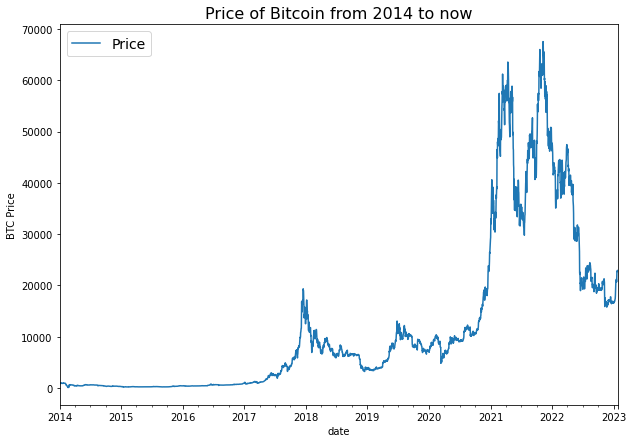

In [13]:
# Visualize closing prices
btc_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 2014 to now', fontsize=16)
plt.legend(fontsize=14);

In [15]:
# Create a helper plotting function
def plot_time_series(
    timesteps,
    prices,
    format='.',
    start=0,
    end=None,
    label=None
):
    plt.plot(timesteps[start:end], prices[start:end], format, label=label)
    plt.xlabel('Date')
    plt.ylabel('Price')
    if label:
        plt.legend(fontsize=14)

    # Display a grid for easier measurement readings
    plt.grid(True)

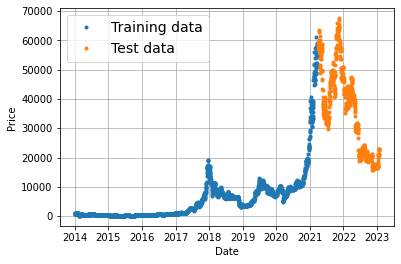

In [16]:
plot_time_series(X_viz, y_viz, label='Training data')
plot_time_series(X_viz_, y_viz_, label='Test data')

### Create windowed datasets

In [17]:
'''
Upon experimentation conducted in the
https://github.com/Ammar-Raneez/FYP_Algorithm/blob/main/experiments/experiments.ipynb
The below were the optimal window and horizon values
'''

HORIZON = 1
WINDOW_SIZE = 7

In [18]:
btc_prices_windowed = btc_prices.copy()

In [19]:
for i in range(WINDOW_SIZE):
    btc_prices_windowed[f'Price+{i+1}'] = btc_prices_windowed['Price'].shift(periods=i+1)

btc_prices_windowed.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
date,,,,,,,,
2014-01-01,815.940002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,856.909973,815.940002,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,884.260010,856.909973,815.940002,NaN,NaN,NaN,NaN,NaN
2014-01-04,924.690002,884.260010,856.909973,815.940002,NaN,NaN,NaN,NaN
2014-01-05,1014.739990,924.690002,884.260010,856.909973,815.940002,NaN,NaN,NaN
2014-01-06,1012.650024,1014.739990,924.690002,884.260010,856.909973,815.940002,NaN,NaN
2014-01-07,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973,815.940002,NaN
2014-01-08,938.840027,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973,815.940002
2014-01-09,936.950012,938.840027,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973


In [20]:
# Create X (windows) and y (horizon)
X = btc_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = btc_prices_windowed.dropna()['Price'].astype(np.float32)

In [21]:
X.head()

,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
date,,,,,,,
2014-01-08,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973,815.940002
2014-01-09,938.840027,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973
2014-01-10,936.950012,938.840027,879.900024,1012.650024,1014.739990,924.690002,884.260010
2014-01-11,957.760010,936.950012,938.840027,879.900024,1012.650024,1014.739990,924.690002
2014-01-12,1005.320007,957.760010,936.950012,938.840027,879.900024,1012.650024,1014.739990


In [22]:
y.head()

date
2014-01-08     938.840027
2014-01-09     936.950012
2014-01-10     957.760010
2014-01-11    1005.320007
2014-01-12     939.789978
Name: Price, dtype: float32

In [23]:
split_size = int(len(X) * .8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2643, 2643, 661, 661)

### Create performant tensorflow datasets

`tf.data` API creates more optimized datasets that can make the model run faster

In [24]:
# create tensorflow Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# batch and prefetch for optimal performance
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

### Create callback functions

In [25]:
# Model checkpoint with a specific filename
def create_model_checkpoint(model_name, save_path='model_checkpoints', monitor_dataset_loss=False):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        verbose=0,
        save_best_only=True,
        monitor='loss' if monitor_dataset_loss else 'val_loss',
    )

# Create a tensorboard callback
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
    )

    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=200,
    restore_best_weights=True
)

# create reduce lr on plateau callback
reduce_lr_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    patience=100,
    verbose=1
)

### Create model architecture

The below architecture was also the best performing from experimentation conducted in [FYP_Algorithm](https://github.com/Ammar-Raneez/FYP_Algorithm/blob/main/experiments/experiments.ipynb)

In [26]:
model_univariate = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.RNN(LTSCell(32), time_major=True, return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu'),
    
    # Number forecasts therefore no need an activation
    tf.keras.layers.Dense(HORIZON, activation='linear')
], name='model_univariate')

In [27]:
#LTC architectures requirer higher learning rate
model_univariate.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = .01),
    loss = tf.keras.losses.MAE,
    metrics = ['mae', 'mse']
)

In [30]:
history_model_univariate = model_univariate.fit(
    train_dataset,
    epochs=5000,
    validation_data=test_dataset,
    callbacks=[
        create_model_checkpoint(model_name=model_univariate.name),
        create_tensorboard_callback(
            dir_name='tensorboard_logs',
            experiment_name=model_univariate.name
        ),
        early_stopping,
        reduce_lr_plateau,
        
    ]
)

Saving TensorBoard log files to: tensorboard_logs/model_univariate/20230129-125617
Epoch 1/5000
3/3 [==============================] - 71s 15s/step - loss: 6317.9624 - mae: 6317.9624 - mse: 112391288.0000 - val_loss: 34769.8477 - val_mae: 34769.8477 - val_mse: 1425050240.0000 - lr: 0.0100
Epoch 2/5000
3/3 [==============================] - 33s 12s/step - loss: 5458.4390 - mae: 5458.4390 - mse: 101007488.0000 - val_loss: 34552.0586 - val_mae: 34552.0586 - val_mse: 1412947584.0000 - lr: 0.0100
Epoch 3/5000
3/3 [==============================] - 33s 12s/step - loss: 5186.0259 - mae: 5186.0259 - mse: 92155976.0000 - val_loss: 33523.0430 - val_mae: 33523.0430 - val_mse: 1357497984.0000 - lr: 0.0100
Epoch 4/5000
3/3 [==============================] - 33s 12s/step - loss: 5404.5132 - mae: 5404.5132 - mse: 91064808.0000 - val_loss: 33068.9297 - val_mae: 33068.9297 - val_mse: 1333928448.0000 - lr: 0.0100
Epoch 5/5000
3/3 [==============================] - 34s 12s/step - loss: 5519.6309 - mae: 5

Epoch 36/5000
3/3 [==============================] - 27s 9s/step - loss: 5435.7144 - mae: 5435.7144 - mse: 92075776.0000 - val_loss: 33533.1055 - val_mae: 33533.1055 - val_mse: 1357917952.0000 - lr: 0.0100
Epoch 37/5000
3/3 [==============================] - 28s 9s/step - loss: 5435.4258 - mae: 5435.4258 - mse: 92073800.0000 - val_loss: 33533.4844 - val_mae: 33533.4844 - val_mse: 1357931264.0000 - lr: 0.0100
Epoch 38/5000
3/3 [==============================] - 27s 9s/step - loss: 5435.1138 - mae: 5435.1138 - mse: 92072168.0000 - val_loss: 33533.9141 - val_mae: 33533.9141 - val_mse: 1357946880.0000 - lr: 0.0100
Epoch 39/5000
3/3 [==============================] - 27s 9s/step - loss: 5434.7637 - mae: 5434.7637 - mse: 92070360.0000 - val_loss: 33534.3477 - val_mae: 33534.3477 - val_mse: 1357962624.0000 - lr: 0.0100
Epoch 40/5000
3/3 [==============================] - 28s 9s/step - loss: 5434.4365 - mae: 5434.4365 - mse: 92069136.0000 - val_loss: 33534.8242 - val_mae: 33534.8242 - val_mse:

Epoch 76/5000
3/3 [==============================] - 29s 9s/step - loss: 5395.3394 - mae: 5395.3394 - mse: 91567552.0000 - val_loss: 33481.1406 - val_mae: 33481.1406 - val_mse: 1353394304.0000 - lr: 0.0100
Epoch 77/5000
3/3 [==============================] - 28s 9s/step - loss: 5392.1748 - mae: 5392.1748 - mse: 91504600.0000 - val_loss: 33470.8359 - val_mae: 33470.8359 - val_mse: 1352657536.0000 - lr: 0.0100
Epoch 78/5000
3/3 [==============================] - 27s 9s/step - loss: 5388.6797 - mae: 5388.6797 - mse: 91434768.0000 - val_loss: 33458.9883 - val_mae: 33458.9883 - val_mse: 1351828480.0000 - lr: 0.0100
Epoch 79/5000
3/3 [==============================] - 28s 9s/step - loss: 5384.7114 - mae: 5384.7119 - mse: 91346600.0000 - val_loss: 33443.8477 - val_mae: 33443.8477 - val_mse: 1350825600.0000 - lr: 0.0100
Epoch 80/5000
3/3 [==============================] - 28s 9s/step - loss: 5380.5312 - mae: 5380.5312 - mse: 91233688.0000 - val_loss: 33424.8711 - val_mae: 33424.8711 - val_mse:

Epoch 105/5000
3/3 [==============================] - 39s 14s/step - loss: 5098.2363 - mae: 5098.2368 - mse: 80379976.0000 - val_loss: 31186.7773 - val_mae: 31186.7773 - val_mse: 1226470016.0000 - lr: 0.0100
Epoch 106/5000
3/3 [==============================] - 39s 14s/step - loss: 5089.0010 - mae: 5089.0010 - mse: 79190624.0000 - val_loss: 30945.9570 - val_mae: 30945.9570 - val_mse: 1215113472.0000 - lr: 0.0100
Epoch 107/5000
3/3 [==============================] - 35s 12s/step - loss: 5116.5840 - mae: 5116.5840 - mse: 79229208.0000 - val_loss: 30821.6523 - val_mae: 30821.6523 - val_mse: 1207415808.0000 - lr: 0.0100
Epoch 108/5000
3/3 [==============================] - 40s 14s/step - loss: 5094.0015 - mae: 5094.0015 - mse: 78182216.0000 - val_loss: 30535.3105 - val_mae: 30535.3105 - val_mse: 1195134080.0000 - lr: 0.0100
Epoch 109/5000
3/3 [==============================] - 39s 14s/step - loss: 5090.9531 - mae: 5090.9531 - mse: 77526016.0000 - val_loss: 30377.1738 - val_mae: 30377.1738 

Epoch 127/5000
3/3 [==============================] - 41s 15s/step - loss: 5161.0630 - mae: 5161.0630 - mse: 77515000.0000 - val_loss: 29186.5879 - val_mae: 29186.5879 - val_mse: 1116872320.0000 - lr: 0.0100
Epoch 128/5000
3/3 [==============================] - 32s 10s/step - loss: 5162.2632 - mae: 5162.2632 - mse: 77507816.0000 - val_loss: 29194.5176 - val_mae: 29194.5176 - val_mse: 1116863104.0000 - lr: 0.0100
Epoch 129/5000
3/3 [==============================] - 31s 10s/step - loss: 5164.6562 - mae: 5164.6562 - mse: 77676968.0000 - val_loss: 29207.5410 - val_mae: 29207.5410 - val_mse: 1117012736.0000 - lr: 0.0100
Epoch 130/5000
3/3 [==============================] - 39s 14s/step - loss: 5154.0190 - mae: 5154.0190 - mse: 77465416.0000 - val_loss: 29182.1328 - val_mae: 29182.1328 - val_mse: 1116377216.0000 - lr: 0.0100
Epoch 131/5000
3/3 [==============================] - 32s 10s/step - loss: 5155.6128 - mae: 5155.6128 - mse: 77414264.0000 - val_loss: 29184.5938 - val_mae: 29184.5938 

KeyboardInterrupt: 

No sign of improvement. Attempt a simple basic model

In [54]:
model_univariate_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.RNN(LTSCell(16), time_major=True, return_sequences=True),
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(HORIZON, activation='linear')
], name='model_univariate_2')

In [55]:
model_univariate_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = .01),
    loss = tf.keras.losses.MAE,
    metrics = ['mae', 'mse']
)

In [56]:
history_model_univariate_2 = model_univariate_2.fit(
    train_dataset,
    epochs=5000,
    validation_data=test_dataset,
    callbacks=[
        create_model_checkpoint(model_name=model_univariate_2.name),
        create_tensorboard_callback(
            dir_name='tensorboard_logs',
            experiment_name=model_univariate_2.name
        ),
        early_stopping,
        reduce_lr_plateau,
    ]
)

Saving TensorBoard log files to: tensorboard_logs/model_univariate_2/20230129-162946
Epoch 1/5000
1/3 [=========>....................] - ETA: 2s - loss: 423.5605 - mae: 423.5605 - mse: 206962.5625INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 4s 1s/step - loss: 4260.2227 - mae: 4260.2227 - mse: 54770080.0000 - val_loss: 17985.7402 - val_mae: 17985.7402 - val_mse: 376103776.0000 - lr: 0.0010
Epoch 2/5000
2/3 [===================>..........] - ETA: 0s - loss: 1195.2158 - mae: 1195.2158 - mse: 3512463.0000INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 1886.4775 - mae: 1886.4775 - mse: 10423141.0000 - val_loss: 4110.4941 - val_mae: 4110.4941 - val_mse: 22907902.0000 - lr: 0.0010
Epoch 3/5000
3/3 [==============================] - 0s 168ms/step - loss: 472.2631 - mae: 472.2631 - mse: 1197199.5000 - val_loss: 5189.1548 - val_mae: 5189.1548 - val_mse: 35542916.0000 - lr: 0.0010
Epoch 4/5000
3/3 [==============================] - 0s 143ms/step - loss: 913.8632 - mae: 913.8632 - mse: 3093886.7500 - val_loss: 5122.5601 - val_mae: 5122.5601 - val_mse: 34723392.0000 - lr: 0.0010
Epoch 5/5000
3/3 [==============================] - ETA: 0s - loss: 473.5496 - mae: 473.5496 - mse: 869483.3125INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 473.5496 - mae: 473.5496 - mse: 869483.3125 - val_loss: 1493.3358 - val_mae: 1493.3358 - val_mse: 4536822.0000 - lr: 0.0010
Epoch 6/5000
3/3 [==============================] - 0s 141ms/step - loss: 510.1746 - mae: 510.1746 - mse: 1498990.3750 - val_loss: 2934.4385 - val_mae: 2934.4385 - val_mse: 12752696.0000 - lr: 0.0010
Epoch 7/5000
3/3 [==============================] - 0s 135ms/step - loss: 554.5396 - mae: 554.5396 - mse: 1447472.3750 - val_loss: 1777.0989 - val_mae: 1777.0989 - val_mse: 5593928.5000 - lr: 0.0010
Epoch 8/5000
3/3 [==============================] - 0s 165ms/step - loss: 287.1004 - mae: 287.1004 - mse: 486667.9062 - val_loss: 2248.0759 - val_mae: 2248.0759 - val_mse: 8655545.0000 - lr: 0.0010
Epoch 9/5000
3/3 [==============================] - 0s 132ms/step - loss: 432.8961 - mae: 432.8961 - mse: 870593.9375 - val_loss: 2558.2769 - val_mae: 2558.2769 - val_mse: 10627984.0000 - lr: 0.0010
Epoch 10/5000
3/3 [===

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 306.7448 - mae: 306.7448 - mse: 500860.1250 - val_loss: 1391.0946 - val_mae: 1391.0946 - val_mse: 3919360.5000 - lr: 0.0010
Epoch 11/5000
3/3 [==============================] - 1s 215ms/step - loss: 358.4265 - mae: 358.4265 - mse: 781313.8125 - val_loss: 1572.8805 - val_mae: 1572.8805 - val_mse: 4529990.5000 - lr: 0.0010
Epoch 12/5000
3/3 [==============================] - 0s 174ms/step - loss: 287.8113 - mae: 287.8113 - mse: 506143.0312 - val_loss: 1506.7014 - val_mae: 1506.7014 - val_mse: 4529115.5000 - lr: 0.0010
Epoch 13/5000
3/3 [==============================] - 1s 642ms/step - loss: 324.8630 - mae: 324.8630 - mse: 567802.1250 - val_loss: 2045.6034 - val_mae: 2045.6034 - val_mse: 7357319.0000 - lr: 0.0010
Epoch 14/5000
3/3 [==============================] - ETA: 0s - loss: 281.1255 - mae: 281.1255 - mse: 439433.8750INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 281.1255 - mae: 281.1255 - mse: 439433.8750 - val_loss: 1343.4286 - val_mae: 1343.4286 - val_mse: 3695489.2500 - lr: 0.0010
Epoch 15/5000
1/3 [=========>....................] - ETA: 0s - loss: 15.1822 - mae: 15.1822 - mse: 991.0377INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 284.9824 - mae: 284.9824 - mse: 516857.3750 - val_loss: 1288.3888 - val_mae: 1288.3888 - val_mse: 3331821.5000 - lr: 0.0010
Epoch 16/5000
3/3 [==============================] - 0s 204ms/step - loss: 246.4840 - mae: 246.4840 - mse: 382426.6562 - val_loss: 1460.0060 - val_mae: 1460.0060 - val_mse: 4215016.0000 - lr: 0.0010
Epoch 17/5000
3/3 [==============================] - 0s 85ms/step - loss: 262.3122 - mae: 262.3122 - mse: 397612.7188 - val_loss: 1373.8583 - val_mae: 1373.8583 - val_mse: 3772012.0000 - lr: 0.0010
Epoch 18/5000
3/3 [==============================] - ETA: 0s - loss: 249.9928 - mae: 249.9928 - mse: 408879.1562INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 249.9928 - mae: 249.9928 - mse: 408879.1562 - val_loss: 1220.1503 - val_mae: 1220.1503 - val_mse: 3013417.0000 - lr: 0.0010
Epoch 19/5000
3/3 [==============================] - 0s 90ms/step - loss: 231.6311 - mae: 231.6311 - mse: 348848.7812 - val_loss: 1275.2354 - val_mae: 1275.2354 - val_mse: 3301946.7500 - lr: 0.0010
Epoch 20/5000
1/3 [=========>....................] - ETA: 0s - loss: 14.8884 - mae: 14.8884 - mse: 839.4272INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 232.9307 - mae: 232.9307 - mse: 331183.7188 - val_loss: 1197.4358 - val_mae: 1197.4358 - val_mse: 2943512.0000 - lr: 0.0010
Epoch 21/5000
1/3 [=========>....................] - ETA: 0s - loss: 13.8206 - mae: 13.8206 - mse: 766.1170INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 225.6108 - mae: 225.6108 - mse: 345403.3125 - val_loss: 1143.0436 - val_mae: 1143.0436 - val_mse: 2708314.2500 - lr: 0.0010
Epoch 22/5000
1/3 [=========>....................] - ETA: 0s - loss: 13.0278 - mae: 13.0278 - mse: 710.8199INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 230.8966 - mae: 230.8966 - mse: 320121.1875 - val_loss: 1127.7815 - val_mae: 1127.7815 - val_mse: 2638837.2500 - lr: 0.0010
Epoch 23/5000
3/3 [==============================] - ETA: 0s - loss: 234.1068 - mae: 234.1068 - mse: 363645.7812INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 234.1068 - mae: 234.1068 - mse: 363645.7812 - val_loss: 1090.3932 - val_mae: 1090.3932 - val_mse: 2480191.2500 - lr: 0.0010
Epoch 24/5000
3/3 [==============================] - 0s 122ms/step - loss: 246.4622 - mae: 246.4622 - mse: 348845.5312 - val_loss: 1188.4779 - val_mae: 1188.4779 - val_mse: 2879907.2500 - lr: 0.0010
Epoch 25/5000
1/3 [=========>....................] - ETA: 0s - loss: 14.1839 - mae: 14.1839 - mse: 702.4341INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 224.6696 - mae: 224.6696 - mse: 340832.1875 - val_loss: 1062.8282 - val_mae: 1062.8282 - val_mse: 2341301.7500 - lr: 0.0010
Epoch 26/5000
3/3 [==============================] - 0s 139ms/step - loss: 212.6105 - mae: 212.6105 - mse: 288279.6875 - val_loss: 1099.0505 - val_mae: 1099.0505 - val_mse: 2524879.5000 - lr: 0.0010
Epoch 27/5000
3/3 [==============================] - 0s 129ms/step - loss: 205.7572 - mae: 205.7572 - mse: 293607.1562 - val_loss: 1064.0692 - val_mae: 1064.0692 - val_mse: 2387642.0000 - lr: 0.0010
Epoch 28/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.9692 - mae: 11.9692 - mse: 611.9069INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 225.4238 - mae: 225.4238 - mse: 310828.8125 - val_loss: 1046.1915 - val_mae: 1046.1915 - val_mse: 2311268.7500 - lr: 0.0010
Epoch 29/5000
3/3 [==============================] - ETA: 0s - loss: 250.8868 - mae: 250.8868 - mse: 380953.5000INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 250.8868 - mae: 250.8868 - mse: 380953.5000 - val_loss: 1043.6566 - val_mae: 1043.6566 - val_mse: 2270176.7500 - lr: 0.0010
Epoch 30/5000
3/3 [==============================] - 0s 97ms/step - loss: 247.6501 - mae: 247.6501 - mse: 363676.7500 - val_loss: 1200.2582 - val_mae: 1200.2582 - val_mse: 2872216.5000 - lr: 0.0010
Epoch 31/5000
3/3 [==============================] - ETA: 0s - loss: 211.7737 - mae: 211.7737 - mse: 304646.5938INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 7s 3s/step - loss: 211.7737 - mae: 211.7737 - mse: 304646.5938 - val_loss: 1043.0841 - val_mae: 1043.0841 - val_mse: 2268682.0000 - lr: 0.0010
Epoch 32/5000
3/3 [==============================] - 0s 126ms/step - loss: 203.9622 - mae: 203.9622 - mse: 276122.2812 - val_loss: 1064.6886 - val_mae: 1064.6886 - val_mse: 2381216.0000 - lr: 0.0010
Epoch 33/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.8747 - mae: 11.8747 - mse: 589.0494INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 199.1349 - mae: 199.1349 - mse: 276186.6562 - val_loss: 1034.9113 - val_mae: 1034.9113 - val_mse: 2273392.5000 - lr: 0.0010
Epoch 34/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.4472 - mae: 11.4472 - mse: 569.2115INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 208.0225 - mae: 208.0225 - mse: 279349.5312 - val_loss: 1025.0726 - val_mae: 1025.0726 - val_mse: 2226942.0000 - lr: 0.0010
Epoch 35/5000
3/3 [==============================] - 0s 134ms/step - loss: 227.8385 - mae: 227.8385 - mse: 327368.8125 - val_loss: 1029.7771 - val_mae: 1029.7771 - val_mse: 2247960.2500 - lr: 0.0010
Epoch 36/5000
3/3 [==============================] - 0s 101ms/step - loss: 250.1104 - mae: 250.1104 - mse: 363793.2812 - val_loss: 1136.2485 - val_mae: 1136.2485 - val_mse: 2624966.0000 - lr: 0.0010
Epoch 37/5000
3/3 [==============================] - 0s 115ms/step - loss: 221.6693 - mae: 221.6693 - mse: 322397.7188 - val_loss: 1030.6766 - val_mae: 1030.6766 - val_mse: 2208787.2500 - lr: 0.0010
Epoch 38/5000
3/3 [==============================] - 0s 108ms/step - loss: 205.9937 - mae: 205.9937 - mse: 278168.9062 - val_loss: 1064.1606 - val_mae: 1064.1606 - val_mse: 2381807.2500 - lr: 0.0010
Epoch 39/5000
3/3 [===

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 228.1197 - mae: 228.1197 - mse: 329283.8750 - val_loss: 1019.8034 - val_mae: 1019.8034 - val_mse: 2210676.2500 - lr: 0.0010
Epoch 42/5000
3/3 [==============================] - 0s 93ms/step - loss: 237.3823 - mae: 237.3823 - mse: 336367.8750 - val_loss: 1118.3931 - val_mae: 1118.3931 - val_mse: 2567186.5000 - lr: 0.0010
Epoch 43/5000
3/3 [==============================] - ETA: 0s - loss: 214.3002 - mae: 214.3002 - mse: 307037.8750INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 214.3002 - mae: 214.3002 - mse: 307037.8750 - val_loss: 1018.1193 - val_mae: 1018.1193 - val_mse: 2188991.5000 - lr: 0.0010
Epoch 44/5000
3/3 [==============================] - 0s 138ms/step - loss: 208.6654 - mae: 208.6654 - mse: 281260.0938 - val_loss: 1045.2329 - val_mae: 1045.2329 - val_mse: 2316205.2500 - lr: 0.0010
Epoch 45/5000
3/3 [==============================] - 0s 156ms/step - loss: 208.3709 - mae: 208.3709 - mse: 293114.7812 - val_loss: 1021.0588 - val_mae: 1021.0588 - val_mse: 2225352.7500 - lr: 0.0010
Epoch 46/5000
3/3 [==============================] - 0s 112ms/step - loss: 222.2560 - mae: 222.2560 - mse: 303369.3125 - val_loss: 1052.4800 - val_mae: 1052.4800 - val_mse: 2342180.7500 - lr: 0.0010
Epoch 47/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.6699 - mae: 11.6699 - mse: 551.5857INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 219.5688 - mae: 219.5688 - mse: 314739.3750 - val_loss: 1012.1833 - val_mae: 1012.1833 - val_mse: 2182771.7500 - lr: 0.0010
Epoch 48/5000
3/3 [==============================] - 0s 132ms/step - loss: 221.4254 - mae: 221.4254 - mse: 303146.6562 - val_loss: 1071.8744 - val_mae: 1071.8744 - val_mse: 2409877.0000 - lr: 0.0010
Epoch 49/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.9738 - mae: 11.9738 - mse: 559.6141INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 210.7159 - mae: 210.7159 - mse: 298273.9375 - val_loss: 1011.3759 - val_mae: 1011.3759 - val_mse: 2182458.0000 - lr: 0.0010
Epoch 50/5000
3/3 [==============================] - 0s 121ms/step - loss: 211.6404 - mae: 211.6404 - mse: 284868.5625 - val_loss: 1037.6232 - val_mae: 1037.6232 - val_mse: 2292356.0000 - lr: 0.0010
Epoch 51/5000
3/3 [==============================] - 0s 102ms/step - loss: 213.7395 - mae: 213.7395 - mse: 302322.9375 - val_loss: 1016.2360 - val_mae: 1016.2360 - val_mse: 2210174.7500 - lr: 0.0010
Epoch 52/5000
3/3 [==============================] - 0s 208ms/step - loss: 228.8310 - mae: 228.8310 - mse: 316047.0000 - val_loss: 1074.6176 - val_mae: 1074.6176 - val_mse: 2418722.7500 - lr: 0.0010
Epoch 53/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.9574 - mae: 11.9574 - mse: 555.8551INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 217.2240 - mae: 217.2240 - mse: 310900.6250 - val_loss: 1010.8958 - val_mae: 1010.8958 - val_mse: 2170632.7500 - lr: 0.0010
Epoch 54/5000
3/3 [==============================] - 0s 125ms/step - loss: 212.1812 - mae: 212.1812 - mse: 286633.5625 - val_loss: 1054.3268 - val_mae: 1054.3268 - val_mse: 2351353.2500 - lr: 0.0010
Epoch 55/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.6058 - mae: 11.6058 - mse: 544.4120INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 206.4764 - mae: 206.4764 - mse: 289126.1250 - val_loss: 1010.5270 - val_mae: 1010.5270 - val_mse: 2186190.7500 - lr: 0.0010
Epoch 56/5000
3/3 [==============================] - 0s 103ms/step - loss: 211.2062 - mae: 211.2062 - mse: 283590.6562 - val_loss: 1033.7616 - val_mae: 1033.7616 - val_mse: 2279445.0000 - lr: 0.0010
Epoch 57/5000
3/3 [==============================] - 0s 112ms/step - loss: 213.4980 - mae: 213.4980 - mse: 301278.0000 - val_loss: 1011.0231 - val_mae: 1011.0231 - val_mse: 2189493.7500 - lr: 0.0010
Epoch 58/5000
3/3 [==============================] - 0s 164ms/step - loss: 224.8066 - mae: 224.8066 - mse: 308479.0625 - val_loss: 1067.9840 - val_mae: 1067.9840 - val_mse: 2393423.7500 - lr: 0.0010
Epoch 59/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.8023 - mae: 11.8023 - mse: 544.8264INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 213.9018 - mae: 213.9018 - mse: 303572.9062 - val_loss: 1006.6482 - val_mae: 1006.6482 - val_mse: 2166709.2500 - lr: 0.0010
Epoch 60/5000
3/3 [==============================] - 0s 98ms/step - loss: 214.7952 - mae: 214.7952 - mse: 290647.8750 - val_loss: 1049.2645 - val_mae: 1049.2645 - val_mse: 2331219.0000 - lr: 0.0010
Epoch 61/5000
3/3 [==============================] - 0s 104ms/step - loss: 210.4475 - mae: 210.4475 - mse: 296082.3125 - val_loss: 1007.2587 - val_mae: 1007.2587 - val_mse: 2173434.2500 - lr: 0.0010
Epoch 62/5000
3/3 [==============================] - 0s 92ms/step - loss: 215.1942 - mae: 215.1942 - mse: 290977.6875 - val_loss: 1042.6907 - val_mae: 1042.6907 - val_mse: 2310387.7500 - lr: 0.0010
Epoch 63/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.3674 - mae: 11.3674 - mse: 525.5549INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 213.3638 - mae: 213.3638 - mse: 301286.9062 - val_loss: 1006.1872 - val_mae: 1006.1872 - val_mse: 2170309.2500 - lr: 0.0010
Epoch 64/5000
3/3 [==============================] - 0s 108ms/step - loss: 218.1887 - mae: 218.1887 - mse: 296234.1562 - val_loss: 1055.7366 - val_mae: 1055.7366 - val_mse: 2353452.5000 - lr: 0.0010
Epoch 65/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.5432 - mae: 11.5432 - mse: 526.3890INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 991ms/step - loss: 211.0762 - mae: 211.0762 - mse: 297553.4688 - val_loss: 1004.9836 - val_mae: 1004.9836 - val_mse: 2167344.5000 - lr: 0.0010
Epoch 66/5000
3/3 [==============================] - 0s 120ms/step - loss: 214.8364 - mae: 214.8364 - mse: 289769.8438 - val_loss: 1047.3846 - val_mae: 1047.3846 - val_mse: 2327007.0000 - lr: 0.0010
Epoch 67/5000
3/3 [==============================] - ETA: 0s - loss: 210.5955 - mae: 210.5955 - mse: 296355.1250INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 210.5955 - mae: 210.5955 - mse: 296355.1250 - val_loss: 1004.2266 - val_mae: 1004.2266 - val_mse: 2167533.0000 - lr: 0.0010
Epoch 68/5000
3/3 [==============================] - 0s 97ms/step - loss: 215.6070 - mae: 215.6070 - mse: 291039.4688 - val_loss: 1047.6715 - val_mae: 1047.6715 - val_mse: 2328288.5000 - lr: 0.0010
Epoch 69/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.3767 - mae: 11.3767 - mse: 514.8567INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 210.9533 - mae: 210.9533 - mse: 297015.2500 - val_loss: 1003.3655 - val_mae: 1003.3655 - val_mse: 2165288.2500 - lr: 0.0010
Epoch 70/5000
3/3 [==============================] - 0s 90ms/step - loss: 216.4184 - mae: 216.4184 - mse: 292082.2812 - val_loss: 1047.0737 - val_mae: 1047.0737 - val_mse: 2326481.2500 - lr: 0.0010
Epoch 71/5000
3/3 [==============================] - ETA: 0s - loss: 211.9186 - mae: 211.9186 - mse: 298776.0312INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 211.9186 - mae: 211.9186 - mse: 298776.0312 - val_loss: 1002.2388 - val_mae: 1002.2388 - val_mse: 2159534.2500 - lr: 0.0010
Epoch 72/5000
3/3 [==============================] - 0s 104ms/step - loss: 214.9779 - mae: 214.9779 - mse: 289553.3750 - val_loss: 1049.7262 - val_mae: 1049.7262 - val_mse: 2335295.5000 - lr: 0.0010
Epoch 73/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.3989 - mae: 11.3989 - mse: 512.5824INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 209.0403 - mae: 209.0403 - mse: 293392.0625 - val_loss: 1001.5802 - val_mae: 1001.5802 - val_mse: 2157836.7500 - lr: 0.0010
Epoch 74/5000
3/3 [==============================] - 1s 282ms/step - loss: 211.2138 - mae: 211.2138 - mse: 282667.9688 - val_loss: 1045.4515 - val_mae: 1045.4515 - val_mse: 2320938.0000 - lr: 0.0010
Epoch 75/5000
3/3 [==============================] - 0s 128ms/step - loss: 205.4007 - mae: 205.4007 - mse: 286145.8125 - val_loss: 1002.1425 - val_mae: 1002.1425 - val_mse: 2164875.5000 - lr: 0.0010
Epoch 76/5000
3/3 [==============================] - 0s 159ms/step - loss: 211.6817 - mae: 211.6817 - mse: 283000.2812 - val_loss: 1034.8832 - val_mae: 1034.8832 - val_mse: 2285762.0000 - lr: 0.0010
Epoch 77/5000
3/3 [==============================] - ETA: 0s - loss: 209.9329 - mae: 209.9329 - mse: 293921.1875INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 209.9329 - mae: 209.9329 - mse: 293921.1875 - val_loss: 1001.1264 - val_mae: 1001.1264 - val_mse: 2160504.5000 - lr: 0.0010
Epoch 78/5000
3/3 [==============================] - 0s 121ms/step - loss: 217.9234 - mae: 217.9235 - mse: 294350.9062 - val_loss: 1051.2036 - val_mae: 1051.2036 - val_mse: 2335726.7500 - lr: 0.0010
Epoch 79/5000
3/3 [==============================] - ETA: 0s - loss: 210.5457 - mae: 210.5457 - mse: 295434.6875INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 210.5457 - mae: 210.5457 - mse: 295434.6875 - val_loss: 998.9116 - val_mae: 998.9116 - val_mse: 2146424.0000 - lr: 0.0010
Epoch 80/5000
3/3 [==============================] - 0s 144ms/step - loss: 212.2738 - mae: 212.2738 - mse: 285019.2500 - val_loss: 1039.3646 - val_mae: 1039.3646 - val_mse: 2297207.0000 - lr: 0.0010
Epoch 81/5000
3/3 [==============================] - 0s 104ms/step - loss: 209.6908 - mae: 209.6908 - mse: 293221.9375 - val_loss: 999.9138 - val_mae: 999.9138 - val_mse: 2153124.7500 - lr: 0.0010
Epoch 82/5000
3/3 [==============================] - 0s 100ms/step - loss: 214.9795 - mae: 214.9795 - mse: 289135.2812 - val_loss: 1044.5978 - val_mae: 1044.5978 - val_mse: 2313705.0000 - lr: 0.0010
Epoch 83/5000
3/3 [==============================] - ETA: 0s - loss: 209.8522 - mae: 209.8522 - mse: 293802.5312INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 209.8522 - mae: 209.8522 - mse: 293802.5312 - val_loss: 997.9575 - val_mae: 997.9575 - val_mse: 2146103.5000 - lr: 0.0010
Epoch 84/5000
3/3 [==============================] - 0s 92ms/step - loss: 213.4469 - mae: 213.4469 - mse: 286360.2812 - val_loss: 1041.9159 - val_mae: 1041.9159 - val_mse: 2306356.2500 - lr: 0.0010
Epoch 85/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.2315 - mae: 11.2315 - mse: 493.6959INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 208.8825 - mae: 208.8825 - mse: 291866.3125 - val_loss: 997.3480 - val_mae: 997.3480 - val_mse: 2148452.5000 - lr: 0.0010
Epoch 86/5000
3/3 [==============================] - 0s 165ms/step - loss: 214.1985 - mae: 214.1985 - mse: 287221.2500 - val_loss: 1041.1609 - val_mae: 1041.1609 - val_mse: 2304845.0000 - lr: 0.0010
Epoch 87/5000
3/3 [==============================] - ETA: 0s - loss: 209.7522 - mae: 209.7522 - mse: 293665.8750INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 209.7522 - mae: 209.7522 - mse: 293665.8750 - val_loss: 995.8185 - val_mae: 995.8185 - val_mse: 2141417.5000 - lr: 0.0010
Epoch 88/5000
3/3 [==============================] - 1s 341ms/step - loss: 212.8532 - mae: 212.8532 - mse: 285146.7188 - val_loss: 1042.4327 - val_mae: 1042.4327 - val_mse: 2308923.2500 - lr: 0.0010
Epoch 89/5000
3/3 [==============================] - 0s 154ms/step - loss: 207.6584 - mae: 207.6584 - mse: 289649.9062 - val_loss: 996.3843 - val_mae: 996.3843 - val_mse: 2146844.5000 - lr: 0.0010
Epoch 90/5000
3/3 [==============================] - 0s 110ms/step - loss: 213.4441 - mae: 213.4441 - mse: 285752.7188 - val_loss: 1038.7100 - val_mae: 1038.7100 - val_mse: 2298062.0000 - lr: 0.0010
Epoch 91/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.1724 - mae: 11.1724 - mse: 491.9558INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 209.5153 - mae: 209.5153 - mse: 292894.0625 - val_loss: 994.7021 - val_mae: 994.7021 - val_mse: 2138575.5000 - lr: 0.0010
Epoch 92/5000
3/3 [==============================] - 0s 123ms/step - loss: 212.5621 - mae: 212.5621 - mse: 284521.9062 - val_loss: 1044.1481 - val_mae: 1044.1481 - val_mse: 2314992.0000 - lr: 0.0010
Epoch 93/5000
3/3 [==============================] - 1s 243ms/step - loss: 205.7449 - mae: 205.7449 - mse: 286052.0000 - val_loss: 994.8441 - val_mae: 994.8441 - val_mse: 2142415.7500 - lr: 0.0010
Epoch 94/5000
3/3 [==============================] - 0s 191ms/step - loss: 210.6342 - mae: 210.6342 - mse: 280654.9688 - val_loss: 1044.0460 - val_mae: 1044.0460 - val_mse: 2314951.7500 - lr: 0.0010
Epoch 95/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.2326 - mae: 11.2326 - mse: 493.5099INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 202.5807 - mae: 202.5807 - mse: 280123.6250 - val_loss: 994.6550 - val_mae: 994.6550 - val_mse: 2143431.2500 - lr: 0.0010
Epoch 96/5000
3/3 [==============================] - 0s 98ms/step - loss: 207.6011 - mae: 207.6011 - mse: 275003.2188 - val_loss: 1034.2567 - val_mae: 1034.2567 - val_mse: 2282465.5000 - lr: 0.0010
Epoch 97/5000
3/3 [==============================] - 0s 121ms/step - loss: 202.3168 - mae: 202.3168 - mse: 279350.7500 - val_loss: 997.8011 - val_mae: 997.8011 - val_mse: 2156234.2500 - lr: 0.0010
Epoch 98/5000
3/3 [==============================] - 0s 104ms/step - loss: 212.9756 - mae: 212.9756 - mse: 283876.3125 - val_loss: 1026.2679 - val_mae: 1026.2679 - val_mse: 2257027.0000 - lr: 0.0010
Epoch 99/5000
1/3 [=========>....................] - ETA: 0s - loss: 10.9491 - mae: 10.9491 - mse: 480.3234INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 213.2985 - mae: 213.2985 - mse: 299169.5625 - val_loss: 992.4239 - val_mae: 992.4239 - val_mse: 2130460.5000 - lr: 0.0010
Epoch 100/5000
3/3 [==============================] - 1s 254ms/step - loss: 215.5560 - mae: 215.5560 - mse: 289981.2500 - val_loss: 1057.8059 - val_mae: 1057.8059 - val_mse: 2358983.5000 - lr: 0.0010
Epoch 101/5000
3/3 [==============================] - 0s 119ms/step - loss: 203.6502 - mae: 203.6502 - mse: 282153.1562 - val_loss: 992.7548 - val_mae: 992.7548 - val_mse: 2133937.5000 - lr: 0.0010
Epoch 102/5000
3/3 [==============================] - 0s 93ms/step - loss: 205.0837 - mae: 205.0837 - mse: 271212.2500 - val_loss: 1034.3625 - val_mae: 1034.3625 - val_mse: 2285869.0000 - lr: 0.0010
Epoch 103/5000
3/3 [==============================] - 0s 109ms/step - loss: 198.8234 - mae: 198.8234 - mse: 272730.5625 - val_loss: 998.4922 - val_mae: 998.4922 - val_mse: 2163829.0000 - lr: 0.0010
Epoch 104/5000
3/3 [=====

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 208.3949 - mae: 208.3949 - mse: 289206.5000 - val_loss: 992.2615 - val_mae: 992.2615 - val_mse: 2135290.0000 - lr: 0.0010
Epoch 106/5000
3/3 [==============================] - 0s 94ms/step - loss: 215.5023 - mae: 215.5023 - mse: 289130.8750 - val_loss: 1047.2186 - val_mae: 1047.2186 - val_mse: 2318904.2500 - lr: 0.0010
Epoch 107/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.2120 - mae: 11.2120 - mse: 475.9570INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 207.0473 - mae: 207.0473 - mse: 288037.4688 - val_loss: 990.8345 - val_mae: 990.8345 - val_mse: 2124560.0000 - lr: 0.0010
Epoch 108/5000
3/3 [==============================] - 0s 90ms/step - loss: 209.5533 - mae: 209.5533 - mse: 278819.2188 - val_loss: 1041.8469 - val_mae: 1041.8469 - val_mse: 2301393.0000 - lr: 0.0010
Epoch 109/5000
3/3 [==============================] - 0s 92ms/step - loss: 201.4512 - mae: 201.4512 - mse: 277518.0312 - val_loss: 992.8132 - val_mae: 992.8132 - val_mse: 2138950.7500 - lr: 0.0010
Epoch 110/5000
3/3 [==============================] - 0s 169ms/step - loss: 208.8807 - mae: 208.8807 - mse: 276835.0000 - val_loss: 1031.7906 - val_mae: 1031.7906 - val_mse: 2272940.2500 - lr: 0.0010
Epoch 111/5000
3/3 [==============================] - 0s 95ms/step - loss: 203.9167 - mae: 203.9167 - mse: 281421.9688 - val_loss: 991.1396 - val_mae: 991.1396 - val_mse: 2135267.0000 - lr: 0.0010
Epoch 112/5000
3/3 [=======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 207.6891 - mae: 207.6891 - mse: 288200.4062 - val_loss: 989.0579 - val_mae: 989.0579 - val_mse: 2126607.5000 - lr: 0.0010
Epoch 114/5000
3/3 [==============================] - 0s 178ms/step - loss: 212.5554 - mae: 212.5554 - mse: 283994.6250 - val_loss: 1037.8735 - val_mae: 1037.8735 - val_mse: 2296022.2500 - lr: 0.0010
Epoch 115/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.0108 - mae: 11.0108 - mse: 460.3342INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 206.3095 - mae: 206.3095 - mse: 285951.2500 - val_loss: 988.7169 - val_mae: 988.7169 - val_mse: 2124775.5000 - lr: 0.0010
Epoch 116/5000
3/3 [==============================] - 0s 100ms/step - loss: 210.2844 - mae: 210.2844 - mse: 280019.8750 - val_loss: 1044.9646 - val_mae: 1044.9646 - val_mse: 2318182.0000 - lr: 0.0010
Epoch 117/5000
3/3 [==============================] - 0s 94ms/step - loss: 199.7500 - mae: 199.7500 - mse: 274306.0938 - val_loss: 989.0718 - val_mae: 989.0718 - val_mse: 2130611.5000 - lr: 0.0010
Epoch 118/5000
3/3 [==============================] - 0s 88ms/step - loss: 205.0488 - mae: 205.0488 - mse: 269934.9375 - val_loss: 1027.0389 - val_mae: 1027.0389 - val_mse: 2259794.2500 - lr: 0.0010
Epoch 119/5000
3/3 [==============================] - 0s 91ms/step - loss: 200.0462 - mae: 200.0462 - mse: 274234.2812 - val_loss: 993.8600 - val_mae: 993.8600 - val_mse: 2148881.7500 - lr: 0.0010
Epoch 120/5000
3/3 [=======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 979ms/step - loss: 209.8222 - mae: 209.8222 - mse: 291408.1875 - val_loss: 987.2578 - val_mae: 987.2578 - val_mse: 2117111.7500 - lr: 0.0010
Epoch 122/5000
3/3 [==============================] - 0s 92ms/step - loss: 213.4623 - mae: 213.4623 - mse: 285660.4062 - val_loss: 1046.8849 - val_mae: 1046.8849 - val_mse: 2323221.0000 - lr: 0.0010
Epoch 123/5000
3/3 [==============================] - 0s 101ms/step - loss: 203.2808 - mae: 203.2808 - mse: 280237.2812 - val_loss: 987.5020 - val_mae: 987.5020 - val_mse: 2122514.5000 - lr: 0.0010
Epoch 124/5000
3/3 [==============================] - 0s 167ms/step - loss: 207.4968 - mae: 207.4968 - mse: 274586.5938 - val_loss: 1035.5278 - val_mae: 1035.5278 - val_mse: 2287532.2500 - lr: 0.0010
Epoch 125/5000
3/3 [==============================] - 0s 96ms/step - loss: 199.3446 - mae: 199.3446 - mse: 272811.9688 - val_loss: 988.7796 - val_mae: 988.7796 - val_mse: 2133202.7500 - lr: 0.0010
Epoch 126/5000
3/3 [===

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 207.2841 - mae: 207.2841 - mse: 287275.2500 - val_loss: 985.9232 - val_mae: 985.9232 - val_mse: 2111631.5000 - lr: 0.0010
Epoch 130/5000
3/3 [==============================] - 0s 172ms/step - loss: 210.0770 - mae: 210.0770 - mse: 279820.0312 - val_loss: 1040.9390 - val_mae: 1040.9390 - val_mse: 2301652.2500 - lr: 0.0010
Epoch 131/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.0321 - mae: 11.0321 - mse: 456.1933INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 200.7411 - mae: 200.7411 - mse: 275134.6250 - val_loss: 985.4533 - val_mae: 985.4533 - val_mse: 2114721.0000 - lr: 0.0010
Epoch 132/5000
3/3 [==============================] - 0s 97ms/step - loss: 204.1415 - mae: 204.1415 - mse: 268472.3750 - val_loss: 1024.2087 - val_mae: 1024.2087 - val_mse: 2250655.2500 - lr: 0.0010
Epoch 133/5000
3/3 [==============================] - 0s 216ms/step - loss: 198.8114 - mae: 198.8114 - mse: 271226.5625 - val_loss: 988.3655 - val_mae: 988.3655 - val_mse: 2132309.0000 - lr: 0.0010
Epoch 134/5000
3/3 [==============================] - 0s 92ms/step - loss: 208.4927 - mae: 208.4927 - mse: 275339.1875 - val_loss: 1023.5821 - val_mae: 1023.5821 - val_mse: 2245760.5000 - lr: 0.0010
Epoch 135/5000
3/3 [==============================] - 0s 98ms/step - loss: 204.8479 - mae: 204.8479 - mse: 282002.1875 - val_loss: 986.0456 - val_mae: 986.0456 - val_mse: 2119222.7500 - lr: 0.0010
Epoch 136/5000
3/3 [=======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 203.4288 - mae: 203.4288 - mse: 279635.2500 - val_loss: 984.6062 - val_mae: 984.6062 - val_mse: 2113426.7500 - lr: 0.0010
Epoch 138/5000
3/3 [==============================] - 0s 120ms/step - loss: 208.1429 - mae: 208.1429 - mse: 274848.9375 - val_loss: 1034.7755 - val_mae: 1034.7755 - val_mse: 2283979.0000 - lr: 0.0010
Epoch 139/5000
3/3 [==============================] - 0s 160ms/step - loss: 200.4864 - mae: 200.4864 - mse: 274503.4375 - val_loss: 984.9832 - val_mae: 984.9832 - val_mse: 2118861.2500 - lr: 0.0010
Epoch 140/5000
3/3 [==============================] - 0s 95ms/step - loss: 207.0345 - mae: 207.0345 - mse: 273455.5938 - val_loss: 1031.8691 - val_mae: 1031.8691 - val_mse: 2274555.0000 - lr: 0.0010
Epoch 141/5000
3/3 [==============================] - 0s 121ms/step - loss: 199.0290 - mae: 199.0290 - mse: 271561.4375 - val_loss: 985.2040 - val_mae: 985.2040 - val_mse: 2120149.5000 - lr: 0.0010
Epoch 142/5000
3/3 [=====

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 206.2893 - mae: 206.2893 - mse: 283221.5312 - val_loss: 983.7171 - val_mae: 983.7171 - val_mse: 2111393.0000 - lr: 0.0010
Epoch 146/5000
3/3 [==============================] - 0s 98ms/step - loss: 213.9554 - mae: 213.9554 - mse: 285801.0000 - val_loss: 1052.0359 - val_mae: 1052.0359 - val_mse: 2335012.5000 - lr: 0.0010
Epoch 147/5000
1/3 [=========>....................] - ETA: 0s - loss: 11.1039 - mae: 11.1039 - mse: 441.6053INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 199.8927 - mae: 199.8927 - mse: 272985.7500 - val_loss: 982.5851 - val_mae: 982.5851 - val_mse: 2108055.0000 - lr: 0.0010
Epoch 148/5000
3/3 [==============================] - 0s 106ms/step - loss: 204.1262 - mae: 204.1262 - mse: 267494.0312 - val_loss: 1026.6592 - val_mae: 1026.6592 - val_mse: 2257758.7500 - lr: 0.0010
Epoch 149/5000
3/3 [==============================] - 1s 344ms/step - loss: 197.0052 - mae: 197.0052 - mse: 267377.2500 - val_loss: 986.1255 - val_mae: 986.1255 - val_mse: 2127834.5000 - lr: 0.0010
Epoch 150/5000
3/3 [==============================] - 0s 138ms/step - loss: 207.6224 - mae: 207.6224 - mse: 272980.5312 - val_loss: 1011.7896 - val_mae: 1011.7896 - val_mse: 2207325.7500 - lr: 0.0010
Epoch 151/5000
3/3 [==============================] - 0s 134ms/step - loss: 206.6680 - mae: 206.6680 - mse: 282956.8125 - val_loss: 985.2219 - val_mae: 985.2219 - val_mse: 2123741.2500 - lr: 0.0010
Epoch 152/5000
3/3 [====

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 191.9039 - mae: 191.9039 - mse: 259461.8125 - val_loss: 980.8688 - val_mae: 980.8688 - val_mse: 2099346.7500 - lr: 0.0010
Epoch 162/5000
3/3 [==============================] - 0s 93ms/step - loss: 191.4355 - mae: 191.4355 - mse: 247122.5312 - val_loss: 997.6612 - val_mae: 997.6612 - val_mse: 2171088.5000 - lr: 0.0010
Epoch 163/5000
3/3 [==============================] - 0s 94ms/step - loss: 191.1499 - mae: 191.1499 - mse: 255816.9062 - val_loss: 988.2797 - val_mae: 988.2797 - val_mse: 2139138.2500 - lr: 0.0010
Epoch 164/5000
3/3 [==============================] - 0s 152ms/step - loss: 203.3781 - mae: 203.3781 - mse: 265368.0625 - val_loss: 1007.1200 - val_mae: 1007.1200 - val_mse: 2194727.5000 - lr: 0.0010
Epoch 165/5000
3/3 [==============================] - 0s 95ms/step - loss: 203.1720 - mae: 203.1720 - mse: 276349.1562 - val_loss: 984.8349 - val_mae: 984.8349 - val_mse: 2121121.5000 - lr: 0.0010
Epoch 166/5000
3/3 [=========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 202.6722 - mae: 202.6722 - mse: 276622.3750 - val_loss: 979.8735 - val_mae: 979.8735 - val_mse: 2094319.0000 - lr: 0.0010
Epoch 168/5000
3/3 [==============================] - 0s 211ms/step - loss: 203.5490 - mae: 203.5490 - mse: 267146.0000 - val_loss: 1033.7983 - val_mae: 1033.7983 - val_mse: 2279234.0000 - lr: 0.0010
Epoch 169/5000
3/3 [==============================] - 0s 93ms/step - loss: 193.9139 - mae: 193.9139 - mse: 261111.9062 - val_loss: 981.3494 - val_mae: 981.3494 - val_mse: 2109881.2500 - lr: 0.0010
Epoch 170/5000
3/3 [==============================] - 0s 124ms/step - loss: 199.1381 - mae: 199.1381 - mse: 259062.5000 - val_loss: 1007.8477 - val_mae: 1007.8477 - val_mse: 2199562.7500 - lr: 0.0010
Epoch 171/5000
3/3 [==============================] - 0s 203ms/step - loss: 197.3305 - mae: 197.3305 - mse: 265796.0312 - val_loss: 983.5959 - val_mae: 983.5959 - val_mse: 2120095.5000 - lr: 0.0010
Epoch 172/5000
3/3 [=====

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 206.2556 - mae: 206.2556 - mse: 281869.1875 - val_loss: 978.7609 - val_mae: 978.7609 - val_mse: 2093934.6250 - lr: 0.0010
Epoch 174/5000
3/3 [==============================] - 0s 100ms/step - loss: 211.0638 - mae: 211.0638 - mse: 280609.5625 - val_loss: 1041.3113 - val_mae: 1041.3113 - val_mse: 2298363.2500 - lr: 0.0010
Epoch 175/5000
3/3 [==============================] - ETA: 0s - loss: 199.0495 - mae: 199.0495 - mse: 269664.0000INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 199.0495 - mae: 199.0495 - mse: 269664.0000 - val_loss: 977.5169 - val_mae: 977.5169 - val_mse: 2095916.3750 - lr: 0.0010
Epoch 176/5000
3/3 [==============================] - 0s 96ms/step - loss: 204.4963 - mae: 204.4963 - mse: 268239.4688 - val_loss: 1027.3983 - val_mae: 1027.3983 - val_mse: 2258567.7500 - lr: 0.0010
Epoch 177/5000
3/3 [==============================] - 0s 103ms/step - loss: 195.5035 - mae: 195.5035 - mse: 263500.8438 - val_loss: 978.0656 - val_mae: 978.0656 - val_mse: 2101136.0000 - lr: 0.0010
Epoch 178/5000
3/3 [==============================] - 0s 93ms/step - loss: 202.0765 - mae: 202.0765 - mse: 263864.6562 - val_loss: 1015.8845 - val_mae: 1015.8845 - val_mse: 2223028.7500 - lr: 0.0010
Epoch 179/5000
3/3 [==============================] - 0s 116ms/step - loss: 196.0575 - mae: 196.0575 - mse: 263771.9688 - val_loss: 980.5065 - val_mae: 980.5065 - val_mse: 2111487.0000 - lr: 0.0010
Epoch 180/5000
3/3 [======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 202.2017 - mae: 202.2017 - mse: 274323.3125 - val_loss: 976.9932 - val_mae: 976.9932 - val_mse: 2094033.0000 - lr: 0.0010
Epoch 182/5000
3/3 [==============================] - 0s 130ms/step - loss: 208.0987 - mae: 208.0987 - mse: 274650.2812 - val_loss: 1027.2325 - val_mae: 1027.2325 - val_mse: 2256531.0000 - lr: 0.0010
Epoch 183/5000
3/3 [==============================] - ETA: 0s - loss: 200.5908 - mae: 200.5908 - mse: 271569.0938INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 200.5908 - mae: 200.5908 - mse: 271569.0938 - val_loss: 976.6478 - val_mae: 976.6478 - val_mse: 2093884.0000 - lr: 0.0010
Epoch 184/5000
3/3 [==============================] - 0s 99ms/step - loss: 206.8288 - mae: 206.8288 - mse: 272326.6250 - val_loss: 1028.1848 - val_mae: 1028.1848 - val_mse: 2259704.0000 - lr: 0.0010
Epoch 185/5000
3/3 [==============================] - 0s 96ms/step - loss: 198.0589 - mae: 198.0589 - mse: 267341.6562 - val_loss: 978.5253 - val_mae: 978.5253 - val_mse: 2103696.5000 - lr: 0.0010
Epoch 186/5000
3/3 [==============================] - 0s 161ms/step - loss: 208.0365 - mae: 208.0365 - mse: 273978.3438 - val_loss: 1023.6037 - val_mae: 1023.6037 - val_mse: 2246408.7500 - lr: 0.0010
Epoch 187/5000
1/3 [=========>....................] - ETA: 0s - loss: 10.6390 - mae: 10.6390 - mse: 408.8889INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 200.8931 - mae: 200.8931 - mse: 271815.0625 - val_loss: 975.7941 - val_mae: 975.7941 - val_mse: 2092403.2500 - lr: 0.0010
Epoch 188/5000
3/3 [==============================] - 0s 131ms/step - loss: 207.6166 - mae: 207.6166 - mse: 273888.6875 - val_loss: 1032.5221 - val_mae: 1032.5221 - val_mse: 2273166.0000 - lr: 0.0010
Epoch 189/5000
3/3 [==============================] - 0s 96ms/step - loss: 197.1247 - mae: 197.1247 - mse: 265639.8438 - val_loss: 977.8490 - val_mae: 977.8490 - val_mse: 2102514.0000 - lr: 0.0010
Epoch 190/5000
3/3 [==============================] - 0s 91ms/step - loss: 206.9364 - mae: 206.9364 - mse: 271858.2812 - val_loss: 1021.0007 - val_mae: 1021.0007 - val_mse: 2238674.0000 - lr: 0.0010
Epoch 191/5000
3/3 [==============================] - 0s 89ms/step - loss: 200.7133 - mae: 200.7133 - mse: 271856.2188 - val_loss: 975.8356 - val_mae: 975.8356 - val_mse: 2093313.3750 - lr: 0.0010
Epoch 192/5000
3/3 [=======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 198.9927 - mae: 198.9927 - mse: 268396.4375 - val_loss: 975.2635 - val_mae: 975.2635 - val_mse: 2092425.1250 - lr: 0.0010
Epoch 200/5000
3/3 [==============================] - 0s 90ms/step - loss: 206.5145 - mae: 206.5145 - mse: 271422.0000 - val_loss: 1025.6353 - val_mae: 1025.6353 - val_mse: 2253153.7500 - lr: 0.0010
Epoch 201/5000
3/3 [==============================] - 0s 88ms/step - loss: 197.7149 - mae: 197.7149 - mse: 266243.8125 - val_loss: 976.0415 - val_mae: 976.0415 - val_mse: 2096668.6250 - lr: 0.0010
Epoch 202/5000
3/3 [==============================] - 0s 93ms/step - loss: 206.5342 - mae: 206.5342 - mse: 271237.2188 - val_loss: 1023.7411 - val_mae: 1023.7411 - val_mse: 2247158.2500 - lr: 0.0010
Epoch 203/5000
1/3 [=========>....................] - ETA: 0s - loss: 10.6004 - mae: 10.6004 - mse: 401.7068INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 198.7119 - mae: 198.7119 - mse: 267734.1250 - val_loss: 974.9257 - val_mae: 974.9257 - val_mse: 2091328.2500 - lr: 0.0010
Epoch 204/5000
3/3 [==============================] - 0s 161ms/step - loss: 206.1244 - mae: 206.1244 - mse: 270679.4688 - val_loss: 1024.9989 - val_mae: 1024.9989 - val_mse: 2250572.2500 - lr: 0.0010
Epoch 205/5000
3/3 [==============================] - 0s 124ms/step - loss: 197.5711 - mae: 197.5711 - mse: 265711.5938 - val_loss: 975.5754 - val_mae: 975.5754 - val_mse: 2094861.1250 - lr: 0.0010
Epoch 206/5000
3/3 [==============================] - 0s 195ms/step - loss: 206.1448 - mae: 206.1448 - mse: 270501.1250 - val_loss: 1022.1453 - val_mae: 1022.1453 - val_mse: 2241790.7500 - lr: 0.0010
Epoch 207/5000
1/3 [=========>....................] - ETA: 0s - loss: 10.5521 - mae: 10.5521 - mse: 396.1066INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 198.6729 - mae: 198.6729 - mse: 267504.6562 - val_loss: 974.0967 - val_mae: 974.0967 - val_mse: 2089185.7500 - lr: 0.0010
Epoch 208/5000
3/3 [==============================] - 0s 97ms/step - loss: 205.7171 - mae: 205.7171 - mse: 269918.3438 - val_loss: 1025.0377 - val_mae: 1025.0377 - val_mse: 2250812.0000 - lr: 0.0010
Epoch 209/5000
3/3 [==============================] - 0s 95ms/step - loss: 197.2857 - mae: 197.2857 - mse: 265381.2500 - val_loss: 975.2381 - val_mae: 975.2381 - val_mse: 2094201.2500 - lr: 0.0010
Epoch 210/5000
3/3 [==============================] - 0s 98ms/step - loss: 205.6775 - mae: 205.6775 - mse: 269616.7812 - val_loss: 1020.8093 - val_mae: 1020.8093 - val_mse: 2238594.2500 - lr: 0.0010
Epoch 211/5000
1/3 [=========>....................] - ETA: 0s - loss: 10.5319 - mae: 10.5319 - mse: 394.9111INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 198.5436 - mae: 198.5436 - mse: 267203.9375 - val_loss: 973.8592 - val_mae: 973.8592 - val_mse: 2089604.2500 - lr: 0.0010
Epoch 212/5000
3/3 [==============================] - 0s 96ms/step - loss: 205.7724 - mae: 205.7724 - mse: 269879.1875 - val_loss: 1025.7129 - val_mae: 1025.7129 - val_mse: 2253546.5000 - lr: 0.0010
Epoch 213/5000
3/3 [==============================] - 0s 109ms/step - loss: 196.6227 - mae: 196.6227 - mse: 264207.7500 - val_loss: 974.6989 - val_mae: 974.6989 - val_mse: 2093790.1250 - lr: 0.0010
Epoch 214/5000
3/3 [==============================] - 0s 159ms/step - loss: 204.9968 - mae: 204.9968 - mse: 268372.7188 - val_loss: 1020.9641 - val_mae: 1020.9641 - val_mse: 2240129.7500 - lr: 0.0010
Epoch 215/5000
3/3 [==============================] - 0s 82ms/step - loss: 197.9262 - mae: 197.9262 - mse: 266244.3125 - val_loss: 974.3068 - val_mae: 974.3068 - val_mse: 2093103.2500 - lr: 0.0010
Epoch 216/5000
3/3 [======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 197.6226 - mae: 197.6226 - mse: 265647.9688 - val_loss: 973.6707 - val_mae: 973.6707 - val_mse: 2091063.7500 - lr: 0.0010
Epoch 220/5000
3/3 [==============================] - 0s 98ms/step - loss: 205.2881 - mae: 205.2881 - mse: 268802.3125 - val_loss: 1023.3922 - val_mae: 1023.3922 - val_mse: 2247018.2500 - lr: 0.0010
Epoch 221/5000
3/3 [==============================] - ETA: 0s - loss: 196.9960 - mae: 196.9960 - mse: 264499.1875INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 196.9960 - mae: 196.9960 - mse: 264499.1875 - val_loss: 973.4828 - val_mae: 973.4828 - val_mse: 2090964.6250 - lr: 0.0010
Epoch 222/5000
3/3 [==============================] - 0s 106ms/step - loss: 204.8927 - mae: 204.8927 - mse: 267995.8125 - val_loss: 1019.3888 - val_mae: 1019.3888 - val_mse: 2235161.5000 - lr: 0.0010
Epoch 223/5000
3/3 [==============================] - 0s 178ms/step - loss: 198.0227 - mae: 198.0227 - mse: 266082.9375 - val_loss: 973.6406 - val_mae: 973.6406 - val_mse: 2091476.2500 - lr: 0.0010
Epoch 224/5000
3/3 [==============================] - 0s 93ms/step - loss: 206.5008 - mae: 206.5008 - mse: 270732.9375 - val_loss: 1031.5098 - val_mae: 1031.5098 - val_mse: 2271465.7500 - lr: 0.0010
Epoch 225/5000
3/3 [==============================] - ETA: 0s - loss: 195.0836 - mae: 195.0836 - mse: 261463.7812INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 195.0836 - mae: 195.0836 - mse: 261463.7812 - val_loss: 971.8198 - val_mae: 971.8198 - val_mse: 2083464.7500 - lr: 0.0010
Epoch 226/5000
3/3 [==============================] - 0s 126ms/step - loss: 199.7046 - mae: 199.7046 - mse: 258984.5625 - val_loss: 1017.9160 - val_mae: 1017.9160 - val_mse: 2229566.7500 - lr: 0.0010
Epoch 227/5000
1/3 [=========>....................] - ETA: 0s - loss: 10.4499 - mae: 10.4499 - mse: 383.2860INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 191.6830 - mae: 191.6830 - mse: 255548.9531 - val_loss: 971.7061 - val_mae: 971.7061 - val_mse: 2082353.7500 - lr: 0.0010
Epoch 228/5000
3/3 [==============================] - 0s 98ms/step - loss: 195.5273 - mae: 195.5273 - mse: 251974.0469 - val_loss: 1001.9169 - val_mae: 1001.9169 - val_mse: 2178962.7500 - lr: 0.0010
Epoch 229/5000
3/3 [==============================] - 0s 90ms/step - loss: 192.1400 - mae: 192.1400 - mse: 255626.2188 - val_loss: 977.4465 - val_mae: 977.4465 - val_mse: 2103179.5000 - lr: 0.0010
Epoch 230/5000
3/3 [==============================] - 0s 153ms/step - loss: 203.0714 - mae: 203.0714 - mse: 264237.9375 - val_loss: 1010.0766 - val_mae: 1010.0766 - val_mse: 2203777.0000 - lr: 0.0010
Epoch 231/5000
3/3 [==============================] - 0s 194ms/step - loss: 199.2208 - mae: 199.2208 - mse: 267526.4062 - val_loss: 974.3766 - val_mae: 974.3766 - val_mse: 2094016.5000 - lr: 0.0010
Epoch 232/5000
3/3 [======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 198.0125 - mae: 198.0125 - mse: 266093.6875 - val_loss: 970.3848 - val_mae: 970.3848 - val_mse: 2077624.1250 - lr: 0.0010
Epoch 234/5000
3/3 [==============================] - 0s 173ms/step - loss: 200.7529 - mae: 200.7529 - mse: 260834.3125 - val_loss: 1019.5609 - val_mae: 1019.5609 - val_mse: 2236669.7500 - lr: 0.0010
Epoch 235/5000
1/3 [=========>....................] - ETA: 0s - loss: 10.4456 - mae: 10.4456 - mse: 382.6859INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 192.2986 - mae: 192.2986 - mse: 256101.1250 - val_loss: 970.3774 - val_mae: 970.3774 - val_mse: 2081273.2500 - lr: 0.0010
Epoch 236/5000
3/3 [==============================] - 0s 151ms/step - loss: 195.9087 - mae: 195.9087 - mse: 252423.4531 - val_loss: 1003.1489 - val_mae: 1003.1489 - val_mse: 2186855.5000 - lr: 0.0010
Epoch 237/5000
3/3 [==============================] - 0s 91ms/step - loss: 191.4260 - mae: 191.4260 - mse: 254087.1406 - val_loss: 972.3476 - val_mae: 972.3476 - val_mse: 2088618.6250 - lr: 0.0010
Epoch 238/5000
3/3 [==============================] - 0s 106ms/step - loss: 197.6434 - mae: 197.6434 - mse: 255010.0156 - val_loss: 1008.2877 - val_mae: 1008.2877 - val_mse: 2197170.0000 - lr: 0.0010
Epoch 239/5000
3/3 [==============================] - 0s 129ms/step - loss: 192.4035 - mae: 192.4035 - mse: 256308.5000 - val_loss: 975.0508 - val_mae: 975.0508 - val_mse: 2093728.7500 - lr: 0.0010
Epoch 240/5000
3/3 [=====

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 4s 2s/step - loss: 200.7496 - mae: 200.7496 - mse: 270966.3750 - val_loss: 969.5345 - val_mae: 969.5345 - val_mse: 2076030.5000 - lr: 0.0010
Epoch 244/5000
3/3 [==============================] - 0s 94ms/step - loss: 203.6682 - mae: 203.6682 - mse: 265953.8750 - val_loss: 1035.2012 - val_mae: 1035.2012 - val_mse: 2284548.5000 - lr: 0.0010
Epoch 245/5000
3/3 [==============================] - ETA: 0s - loss: 190.8257 - mae: 190.8257 - mse: 254271.4844INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 190.8257 - mae: 190.8257 - mse: 254271.4844 - val_loss: 968.2896 - val_mae: 968.2896 - val_mse: 2073706.1250 - lr: 0.0010
Epoch 246/5000
3/3 [==============================] - 0s 111ms/step - loss: 190.9860 - mae: 190.9860 - mse: 243898.3125 - val_loss: 996.5945 - val_mae: 996.5945 - val_mse: 2169888.7500 - lr: 0.0010
Epoch 247/5000
3/3 [==============================] - 0s 92ms/step - loss: 187.4173 - mae: 187.4173 - mse: 246992.3438 - val_loss: 975.9682 - val_mae: 975.9682 - val_mse: 2103533.0000 - lr: 0.0010
Epoch 248/5000
3/3 [==============================] - 0s 96ms/step - loss: 195.8035 - mae: 195.8035 - mse: 251038.7031 - val_loss: 998.0990 - val_mae: 998.0990 - val_mse: 2168614.7500 - lr: 0.0010
Epoch 249/5000
3/3 [==============================] - 0s 121ms/step - loss: 192.9520 - mae: 192.9520 - mse: 256232.5625 - val_loss: 975.1497 - val_mae: 975.1497 - val_mse: 2097154.5000 - lr: 0.0010
Epoch 250/5000
3/3 [==========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 980ms/step - loss: 191.2615 - mae: 191.2615 - mse: 254577.1094 - val_loss: 968.0222 - val_mae: 968.0222 - val_mse: 2071842.2500 - lr: 0.0010
Epoch 256/5000
3/3 [==============================] - 0s 96ms/step - loss: 191.6935 - mae: 191.6935 - mse: 245600.3281 - val_loss: 999.4513 - val_mae: 999.4513 - val_mse: 2175371.7500 - lr: 0.0010
Epoch 257/5000
3/3 [==============================] - 0s 101ms/step - loss: 187.1396 - mae: 187.1396 - mse: 246363.0000 - val_loss: 973.9396 - val_mae: 973.9396 - val_mse: 2095399.8750 - lr: 0.0010
Epoch 258/5000
3/3 [==============================] - 0s 97ms/step - loss: 194.1594 - mae: 194.1594 - mse: 248652.3281 - val_loss: 995.7756 - val_mae: 995.7756 - val_mse: 2158892.5000 - lr: 0.0010
Epoch 259/5000
3/3 [==============================] - 0s 97ms/step - loss: 192.9159 - mae: 192.9159 - mse: 256230.1562 - val_loss: 975.3984 - val_mae: 975.3984 - val_mse: 2095335.0000 - lr: 0.0010
Epoch 260/5000
3/3 [========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 197.0596 - mae: 197.0596 - mse: 264211.0625 - val_loss: 967.7035 - val_mae: 967.7035 - val_mse: 2072385.8750 - lr: 0.0010
Epoch 276/5000
3/3 [==============================] - 0s 181ms/step - loss: 199.6055 - mae: 199.6055 - mse: 258838.9531 - val_loss: 1015.4938 - val_mae: 1015.4938 - val_mse: 2224584.2500 - lr: 0.0010
Epoch 277/5000
3/3 [==============================] - 0s 103ms/step - loss: 191.6397 - mae: 191.6397 - mse: 254439.6562 - val_loss: 968.5666 - val_mae: 968.5666 - val_mse: 2081393.8750 - lr: 0.0010
Epoch 278/5000
3/3 [==============================] - 0s 111ms/step - loss: 197.2713 - mae: 197.2713 - mse: 254215.1406 - val_loss: 998.5475 - val_mae: 998.5475 - val_mse: 2173353.5000 - lr: 0.0010
Epoch 279/5000
3/3 [==============================] - 0s 92ms/step - loss: 196.0179 - mae: 196.0179 - mse: 261399.0938 - val_loss: 972.5703 - val_mae: 972.5703 - val_mse: 2095111.7500 - lr: 0.0010
Epoch 280/5000
3/3 [=======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 199.3457 - mae: 199.3457 - mse: 267728.0938 - val_loss: 967.5928 - val_mae: 967.5928 - val_mse: 2071648.2500 - lr: 0.0010
Epoch 282/5000
3/3 [==============================] - 0s 96ms/step - loss: 202.6153 - mae: 202.6153 - mse: 264052.6875 - val_loss: 1025.6986 - val_mae: 1025.6986 - val_mse: 2252509.0000 - lr: 0.0010
Epoch 283/5000
3/3 [==============================] - 0s 100ms/step - loss: 191.5678 - mae: 191.5678 - mse: 254370.1719 - val_loss: 968.1818 - val_mae: 968.1818 - val_mse: 2076094.3750 - lr: 0.0010
Epoch 284/5000
3/3 [==============================] - 0s 94ms/step - loss: 196.2618 - mae: 196.2618 - mse: 252326.4062 - val_loss: 1003.3788 - val_mae: 1003.3788 - val_mse: 2183071.0000 - lr: 0.0010
Epoch 285/5000
3/3 [==============================] - 0s 88ms/step - loss: 192.0933 - mae: 192.0933 - mse: 254969.9219 - val_loss: 973.2448 - val_mae: 973.2448 - val_mse: 2092647.3750 - lr: 0.0010
Epoch 286/5000
3/3 [=======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 5s 2s/step - loss: 195.7375 - mae: 195.7375 - mse: 261464.2188 - val_loss: 967.2128 - val_mae: 967.2128 - val_mse: 2076573.6250 - lr: 0.0010
Epoch 290/5000
3/3 [==============================] - 0s 92ms/step - loss: 202.3387 - mae: 202.3387 - mse: 262934.6250 - val_loss: 1023.0067 - val_mae: 1023.0067 - val_mse: 2247898.7500 - lr: 0.0010
Epoch 291/5000
1/3 [=========>....................] - ETA: 0s - loss: 10.3797 - mae: 10.3797 - mse: 356.8495INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 191.7725 - mae: 191.7725 - mse: 255033.6094 - val_loss: 966.4415 - val_mae: 966.4415 - val_mse: 2071899.7500 - lr: 0.0010
Epoch 292/5000
3/3 [==============================] - 0s 98ms/step - loss: 194.1576 - mae: 194.1576 - mse: 248683.2500 - val_loss: 1009.3728 - val_mae: 1009.3728 - val_mse: 2206222.5000 - lr: 0.0010
Epoch 293/5000
3/3 [==============================] - 0s 101ms/step - loss: 186.6748 - mae: 186.6748 - mse: 245527.0938 - val_loss: 967.9752 - val_mae: 967.9752 - val_mse: 2078095.6250 - lr: 0.0010
Epoch 294/5000
3/3 [==============================] - 0s 88ms/step - loss: 190.4790 - mae: 190.4790 - mse: 242629.4062 - val_loss: 988.0406 - val_mae: 988.0406 - val_mse: 2138015.5000 - lr: 0.0010
Epoch 295/5000
3/3 [==============================] - 0s 91ms/step - loss: 189.8747 - mae: 189.8747 - mse: 250477.6875 - val_loss: 973.2335 - val_mae: 973.2335 - val_mse: 2091557.3750 - lr: 0.0010
Epoch 296/5000
3/3 [=========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 196.6783 - mae: 196.6783 - mse: 263062.9062 - val_loss: 965.7117 - val_mae: 965.7117 - val_mse: 2068801.8750 - lr: 0.0010
Epoch 300/5000
3/3 [==============================] - 0s 197ms/step - loss: 199.2978 - mae: 199.2978 - mse: 257846.7188 - val_loss: 1013.5935 - val_mae: 1013.5935 - val_mse: 2219937.7500 - lr: 0.0010
Epoch 301/5000
3/3 [==============================] - 0s 99ms/step - loss: 191.4731 - mae: 191.4731 - mse: 253790.6562 - val_loss: 966.5720 - val_mae: 966.5720 - val_mse: 2075534.0000 - lr: 0.0010
Epoch 302/5000
3/3 [==============================] - 0s 124ms/step - loss: 195.6344 - mae: 195.6344 - mse: 251211.5312 - val_loss: 1009.6396 - val_mae: 1009.6396 - val_mse: 2204609.0000 - lr: 0.0010
Epoch 303/5000
3/3 [==============================] - 0s 93ms/step - loss: 189.0696 - mae: 189.0696 - mse: 247429.5625 - val_loss: 973.1894 - val_mae: 973.1894 - val_mse: 2097268.7500 - lr: 0.0010
Epoch 304/5000
3/3 [======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 191.5955 - mae: 191.5955 - mse: 254132.6719 - val_loss: 965.2184 - val_mae: 965.2184 - val_mse: 2069039.2500 - lr: 0.0010
Epoch 312/5000
3/3 [==============================] - 0s 99ms/step - loss: 194.1862 - mae: 194.1862 - mse: 249003.4375 - val_loss: 1004.7243 - val_mae: 1004.7243 - val_mse: 2191308.0000 - lr: 0.0010
Epoch 313/5000
3/3 [==============================] - 0s 92ms/step - loss: 187.7908 - mae: 187.7908 - mse: 246649.4062 - val_loss: 966.6094 - val_mae: 966.6094 - val_mse: 2073077.0000 - lr: 0.0010
Epoch 314/5000
3/3 [==============================] - 0s 102ms/step - loss: 190.5322 - mae: 190.5322 - mse: 242389.1875 - val_loss: 993.7541 - val_mae: 993.7541 - val_mse: 2154606.5000 - lr: 0.0010
Epoch 315/5000
3/3 [==============================] - 0s 117ms/step - loss: 187.9252 - mae: 187.9252 - mse: 247003.6094 - val_loss: 972.2941 - val_mae: 972.2941 - val_mse: 2090075.6250 - lr: 0.0010
Epoch 316/5000
3/3 [========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 197.1092 - mae: 197.1092 - mse: 263566.2500 - val_loss: 965.0830 - val_mae: 965.0830 - val_mse: 2064623.7500 - lr: 0.0010
Epoch 320/5000
3/3 [==============================] - 0s 116ms/step - loss: 198.8843 - mae: 198.8843 - mse: 256712.8438 - val_loss: 1013.7158 - val_mae: 1013.7158 - val_mse: 2218860.5000 - lr: 0.0010
Epoch 321/5000
3/3 [==============================] - ETA: 0s - loss: 190.6911 - mae: 190.6911 - mse: 252224.6250INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 190.6911 - mae: 190.6911 - mse: 252224.6250 - val_loss: 964.7021 - val_mae: 964.7021 - val_mse: 2067501.8750 - lr: 0.0010
Epoch 322/5000
3/3 [==============================] - 1s 168ms/step - loss: 192.9880 - mae: 192.9880 - mse: 246490.0312 - val_loss: 999.1765 - val_mae: 999.1765 - val_mse: 2175347.7500 - lr: 0.0010
Epoch 323/5000
3/3 [==============================] - 0s 118ms/step - loss: 188.3228 - mae: 188.3228 - mse: 247298.2969 - val_loss: 965.7245 - val_mae: 965.7245 - val_mse: 2071192.6250 - lr: 0.0010
Epoch 324/5000
3/3 [==============================] - 0s 98ms/step - loss: 191.0980 - mae: 191.0980 - mse: 243320.8125 - val_loss: 992.1966 - val_mae: 992.1966 - val_mse: 2150448.0000 - lr: 0.0010
Epoch 325/5000
3/3 [==============================] - 0s 91ms/step - loss: 188.6718 - mae: 188.6718 - mse: 247860.1406 - val_loss: 970.6138 - val_mae: 970.6138 - val_mse: 2084902.0000 - lr: 0.0010
Epoch 326/5000
3/3 [==========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 196.5836 - mae: 196.5836 - mse: 262829.6875 - val_loss: 964.6441 - val_mae: 964.6441 - val_mse: 2064578.3750 - lr: 0.0010
Epoch 330/5000
3/3 [==============================] - 0s 199ms/step - loss: 199.1539 - mae: 199.1539 - mse: 257522.4844 - val_loss: 1013.1315 - val_mae: 1013.1315 - val_mse: 2216956.0000 - lr: 0.0010
Epoch 331/5000
1/3 [=========>....................] - ETA: 0s - loss: 10.1937 - mae: 10.1937 - mse: 339.3607INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 190.8179 - mae: 190.8179 - mse: 252489.5000 - val_loss: 963.7066 - val_mae: 963.7066 - val_mse: 2065452.5000 - lr: 0.0010
Epoch 332/5000
3/3 [==============================] - 0s 186ms/step - loss: 193.2652 - mae: 193.2652 - mse: 247226.3594 - val_loss: 1000.7905 - val_mae: 1000.7905 - val_mse: 2179852.5000 - lr: 0.0010
Epoch 333/5000
3/3 [==============================] - 0s 148ms/step - loss: 187.4154 - mae: 187.4154 - mse: 245742.3438 - val_loss: 965.9287 - val_mae: 965.9287 - val_mse: 2073230.3750 - lr: 0.0010
Epoch 334/5000
3/3 [==============================] - 0s 186ms/step - loss: 190.7986 - mae: 190.7986 - mse: 242670.6875 - val_loss: 991.5298 - val_mae: 991.5298 - val_mse: 2149879.0000 - lr: 0.0010
Epoch 335/5000
3/3 [==============================] - 0s 162ms/step - loss: 189.0218 - mae: 189.0218 - mse: 248036.3281 - val_loss: 967.5358 - val_mae: 967.5358 - val_mse: 2074640.2500 - lr: 0.0010
Epoch 336/5000
3/3 [======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 189.4099 - mae: 189.4099 - mse: 250566.1719 - val_loss: 962.5406 - val_mae: 962.5406 - val_mse: 2057560.7500 - lr: 0.0010
Epoch 344/5000
3/3 [==============================] - 0s 191ms/step - loss: 188.4850 - mae: 188.4850 - mse: 239655.3281 - val_loss: 989.7868 - val_mae: 989.7868 - val_mse: 2150095.5000 - lr: 0.0010
Epoch 345/5000
3/3 [==============================] - 1s 230ms/step - loss: 185.0722 - mae: 185.0722 - mse: 241813.4375 - val_loss: 968.3431 - val_mae: 968.3431 - val_mse: 2085117.5000 - lr: 0.0010
Epoch 346/5000
3/3 [==============================] - 0s 180ms/step - loss: 191.9382 - mae: 191.9382 - mse: 244023.3750 - val_loss: 991.5015 - val_mae: 991.5015 - val_mse: 2151555.0000 - lr: 0.0010
Epoch 347/5000
3/3 [==============================] - 0s 164ms/step - loss: 189.8622 - mae: 189.8622 - mse: 249853.1250 - val_loss: 966.5710 - val_mae: 966.5710 - val_mse: 2074736.1250 - lr: 0.0010
Epoch 348/5000
3/3 [========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 2s/step - loss: 196.2276 - mae: 196.2276 - mse: 261052.4219 - val_loss: 962.1523 - val_mae: 962.1523 - val_mse: 2062020.7500 - lr: 0.0010
Epoch 364/5000
3/3 [==============================] - 0s 187ms/step - loss: 200.8244 - mae: 200.8244 - mse: 259770.1094 - val_loss: 1020.8936 - val_mae: 1020.8936 - val_mse: 2241828.5000 - lr: 0.0010
Epoch 365/5000
3/3 [==============================] - ETA: 0s - loss: 189.4776 - mae: 189.4776 - mse: 249910.3906INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 189.4776 - mae: 189.4776 - mse: 249910.3906 - val_loss: 961.3279 - val_mae: 961.3279 - val_mse: 2058566.8750 - lr: 0.0010
Epoch 366/5000
3/3 [==============================] - 0s 173ms/step - loss: 190.0097 - mae: 190.0097 - mse: 241235.5000 - val_loss: 996.0710 - val_mae: 996.0710 - val_mse: 2167746.5000 - lr: 0.0010
Epoch 367/5000
3/3 [==============================] - 0s 156ms/step - loss: 185.4047 - mae: 185.4047 - mse: 242252.3281 - val_loss: 965.6028 - val_mae: 965.6028 - val_mse: 2076865.1250 - lr: 0.0010
Epoch 368/5000
3/3 [==============================] - 0s 139ms/step - loss: 190.1217 - mae: 190.1217 - mse: 241174.3750 - val_loss: 983.9175 - val_mae: 983.9175 - val_mse: 2129866.7500 - lr: 0.0010
Epoch 369/5000
3/3 [==============================] - 0s 157ms/step - loss: 189.5529 - mae: 189.5529 - mse: 248771.5312 - val_loss: 971.6000 - val_mae: 971.6000 - val_mse: 2092858.2500 - lr: 0.0010
Epoch 370/5000
3/3 [========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 190.5561 - mae: 190.5561 - mse: 251615.2188 - val_loss: 961.2846 - val_mae: 961.2846 - val_mse: 2055686.0000 - lr: 0.0010
Epoch 374/5000
3/3 [==============================] - 0s 176ms/step - loss: 190.1817 - mae: 190.1817 - mse: 241702.5938 - val_loss: 999.1622 - val_mae: 999.1622 - val_mse: 2177862.7500 - lr: 0.0010
Epoch 375/5000
3/3 [==============================] - 0s 144ms/step - loss: 184.3739 - mae: 184.3739 - mse: 240267.0938 - val_loss: 963.7667 - val_mae: 963.7667 - val_mse: 2069703.1250 - lr: 0.0010
Epoch 376/5000
3/3 [==============================] - 0s 163ms/step - loss: 185.3364 - mae: 185.3364 - mse: 234159.7031 - val_loss: 963.4680 - val_mae: 963.4680 - val_mse: 2068941.8750 - lr: 0.0010
Epoch 377/5000
3/3 [==============================] - 0s 192ms/step - loss: 195.4355 - mae: 195.4355 - mse: 256634.3594 - val_loss: 1005.8445 - val_mae: 1005.8445 - val_mse: 2194455.5000 - lr: 0.0010
Epoch 378/5000
3/3 [======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 4s 2s/step - loss: 182.3908 - mae: 182.3908 - mse: 239087.6094 - val_loss: 960.2365 - val_mae: 960.2365 - val_mse: 2053612.8750 - lr: 0.0010
Epoch 382/5000
3/3 [==============================] - 1s 262ms/step - loss: 179.8210 - mae: 179.8210 - mse: 227603.8125 - val_loss: 964.3345 - val_mae: 964.3345 - val_mse: 2080606.2500 - lr: 0.0010
Epoch 383/5000
3/3 [==============================] - 1s 279ms/step - loss: 183.3159 - mae: 183.3159 - mse: 238098.8438 - val_loss: 981.3134 - val_mae: 981.3134 - val_mse: 2130665.0000 - lr: 0.0010
Epoch 384/5000
3/3 [==============================] - 1s 587ms/step - loss: 197.1568 - mae: 197.1568 - mse: 250583.9688 - val_loss: 985.3929 - val_mae: 985.3929 - val_mse: 2138925.0000 - lr: 0.0010
Epoch 385/5000
3/3 [==============================] - 1s 339ms/step - loss: 199.8394 - mae: 199.8394 - mse: 267190.2188 - val_loss: 967.1128 - val_mae: 967.1128 - val_mse: 2084239.2500 - lr: 0.0010
Epoch 386/5000
3/3 [========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 2s/step - loss: 194.4793 - mae: 194.4793 - mse: 259190.0469 - val_loss: 960.1250 - val_mae: 960.1250 - val_mse: 2056831.3750 - lr: 0.0010
Epoch 388/5000
3/3 [==============================] - 0s 203ms/step - loss: 195.5771 - mae: 195.5771 - mse: 250269.0312 - val_loss: 1006.5908 - val_mae: 1006.5908 - val_mse: 2202315.2500 - lr: 0.0010
Epoch 389/5000
3/3 [==============================] - 1s 346ms/step - loss: 188.0228 - mae: 188.0228 - mse: 246888.0312 - val_loss: 963.4315 - val_mae: 963.4315 - val_mse: 2072204.2500 - lr: 0.0010
Epoch 390/5000
3/3 [==============================] - 1s 244ms/step - loss: 193.4733 - mae: 193.4733 - mse: 246230.0156 - val_loss: 996.5903 - val_mae: 996.5903 - val_mse: 2169207.0000 - lr: 0.0010
Epoch 391/5000
3/3 [==============================] - 0s 219ms/step - loss: 189.7041 - mae: 189.7041 - mse: 249513.2344 - val_loss: 964.9756 - val_mae: 964.9756 - val_mse: 2075185.0000 - lr: 0.0010
Epoch 392/5000
3/3 [======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 190.7831 - mae: 190.7831 - mse: 252265.5781 - val_loss: 959.9899 - val_mae: 959.9899 - val_mse: 2060532.7500 - lr: 0.0010
Epoch 398/5000
3/3 [==============================] - 0s 116ms/step - loss: 192.2296 - mae: 192.2296 - mse: 244205.8594 - val_loss: 1002.8158 - val_mae: 1002.8158 - val_mse: 2192441.7500 - lr: 0.0010
Epoch 399/5000
3/3 [==============================] - 0s 117ms/step - loss: 185.4892 - mae: 185.4892 - mse: 242698.7500 - val_loss: 962.6017 - val_mae: 962.6017 - val_mse: 2068622.5000 - lr: 0.0010
Epoch 400/5000
3/3 [==============================] - 0s 94ms/step - loss: 188.8203 - mae: 188.8203 - mse: 238608.0781 - val_loss: 985.0031 - val_mae: 985.0031 - val_mse: 2134529.2500 - lr: 0.0010
Epoch 401/5000
3/3 [==============================] - 0s 109ms/step - loss: 187.7012 - mae: 187.7012 - mse: 246109.5938 - val_loss: 967.9523 - val_mae: 967.9523 - val_mse: 2082130.6250 - lr: 0.0010
Epoch 402/5000
3/3 [=======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 189.6840 - mae: 189.6840 - mse: 249830.4844 - val_loss: 959.5031 - val_mae: 959.5031 - val_mse: 2055999.8750 - lr: 0.0010
Epoch 408/5000
3/3 [==============================] - 1s 273ms/step - loss: 189.7297 - mae: 189.7297 - mse: 240690.7500 - val_loss: 994.4041 - val_mae: 994.4041 - val_mse: 2167352.2500 - lr: 0.0010
Epoch 409/5000
3/3 [==============================] - 0s 107ms/step - loss: 184.6904 - mae: 184.6904 - mse: 240831.2812 - val_loss: 962.6552 - val_mae: 962.6552 - val_mse: 2069754.2500 - lr: 0.0010
Epoch 410/5000
3/3 [==============================] - 0s 94ms/step - loss: 188.3074 - mae: 188.3074 - mse: 237828.0000 - val_loss: 984.4525 - val_mae: 984.4525 - val_mse: 2133033.5000 - lr: 0.0010
Epoch 411/5000
3/3 [==============================] - 0s 91ms/step - loss: 187.5867 - mae: 187.5867 - mse: 245386.3594 - val_loss: 968.6447 - val_mae: 968.6447 - val_mse: 2084855.8750 - lr: 0.0010
Epoch 412/5000
3/3 [==========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 189.9733 - mae: 189.9733 - mse: 249437.5625 - val_loss: 959.3381 - val_mae: 959.3381 - val_mse: 2053707.8750 - lr: 0.0010
Epoch 428/5000
3/3 [==============================] - 0s 155ms/step - loss: 191.5434 - mae: 191.5434 - mse: 243548.5938 - val_loss: 999.4582 - val_mae: 999.4582 - val_mse: 2178279.2500 - lr: 0.0010
Epoch 429/5000
3/3 [==============================] - 0s 110ms/step - loss: 184.9667 - mae: 184.9667 - mse: 241177.5781 - val_loss: 960.7296 - val_mae: 960.7296 - val_mse: 2061060.5000 - lr: 0.0010
Epoch 430/5000
3/3 [==============================] - 0s 103ms/step - loss: 187.7813 - mae: 187.7813 - mse: 236981.3906 - val_loss: 981.9866 - val_mae: 981.9866 - val_mse: 2124685.2500 - lr: 0.0010
Epoch 431/5000
3/3 [==============================] - 0s 96ms/step - loss: 188.0231 - mae: 188.0231 - mse: 246237.5938 - val_loss: 971.8953 - val_mae: 971.8953 - val_mse: 2095678.1250 - lr: 0.0010
Epoch 432/5000
3/3 [=========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 193.5909 - mae: 193.5909 - mse: 256521.2812 - val_loss: 959.2599 - val_mae: 959.2599 - val_mse: 2052962.1250 - lr: 0.0010
Epoch 436/5000
3/3 [==============================] - 1s 336ms/step - loss: 194.1394 - mae: 194.1394 - mse: 248095.4375 - val_loss: 1008.6835 - val_mae: 1008.6835 - val_mse: 2208840.5000 - lr: 0.0010
Epoch 437/5000
3/3 [==============================] - 0s 166ms/step - loss: 185.2173 - mae: 185.2173 - mse: 242031.4062 - val_loss: 959.4640 - val_mae: 959.4640 - val_mse: 2057276.2500 - lr: 0.0010
Epoch 438/5000
3/3 [==============================] - 1s 174ms/step - loss: 186.1161 - mae: 186.1161 - mse: 234337.8594 - val_loss: 983.5024 - val_mae: 983.5024 - val_mse: 2133174.5000 - lr: 0.0010
Epoch 439/5000
3/3 [==============================] - 0s 168ms/step - loss: 184.5972 - mae: 184.5972 - mse: 240184.9844 - val_loss: 964.1440 - val_mae: 964.1440 - val_mse: 2074831.2500 - lr: 0.0010
Epoch 440/5000
3/3 [======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 196.6788 - mae: 196.6788 - mse: 261211.8750 - val_loss: 959.0248 - val_mae: 959.0248 - val_mse: 2050795.1250 - lr: 0.0010
Epoch 466/5000
3/3 [==============================] - 0s 106ms/step - loss: 197.5066 - mae: 197.5066 - mse: 253208.3438 - val_loss: 1020.3809 - val_mae: 1020.3809 - val_mse: 2243225.0000 - lr: 0.0010
Epoch 467/5000
3/3 [==============================] - ETA: 0s - loss: 185.8771 - mae: 185.8771 - mse: 242967.5781INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 185.8771 - mae: 185.8771 - mse: 242967.5781 - val_loss: 958.8824 - val_mae: 958.8824 - val_mse: 2054218.5000 - lr: 0.0010
Epoch 468/5000
3/3 [==============================] - 0s 103ms/step - loss: 186.8270 - mae: 186.8270 - mse: 235284.1875 - val_loss: 985.1729 - val_mae: 985.1729 - val_mse: 2137581.2500 - lr: 0.0010
Epoch 469/5000
3/3 [==============================] - 0s 108ms/step - loss: 184.4503 - mae: 184.4503 - mse: 239873.8906 - val_loss: 962.8237 - val_mae: 962.8237 - val_mse: 2068854.7500 - lr: 0.0010
Epoch 470/5000
3/3 [==============================] - 1s 246ms/step - loss: 189.0435 - mae: 189.0435 - mse: 238513.1250 - val_loss: 987.4333 - val_mae: 987.4333 - val_mse: 2138982.5000 - lr: 0.0010
Epoch 471/5000
3/3 [==============================] - 0s 92ms/step - loss: 186.6428 - mae: 186.6428 - mse: 244110.8125 - val_loss: 967.3683 - val_mae: 967.3683 - val_mse: 2077058.5000 - lr: 0.0010
Epoch 472/5000
3/3 [=========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 187.1187 - mae: 187.1187 - mse: 245134.5000 - val_loss: 957.7851 - val_mae: 957.7851 - val_mse: 2048794.7500 - lr: 0.0010
Epoch 478/5000
3/3 [==============================] - 0s 152ms/step - loss: 186.4815 - mae: 186.4815 - mse: 234930.7969 - val_loss: 987.8571 - val_mae: 987.8571 - val_mse: 2148593.0000 - lr: 0.0010
Epoch 479/5000
3/3 [==============================] - 0s 127ms/step - loss: 182.6321 - mae: 182.6321 - mse: 236875.5781 - val_loss: 961.3476 - val_mae: 961.3476 - val_mse: 2068176.1250 - lr: 0.0010
Epoch 480/5000
3/3 [==============================] - 0s 105ms/step - loss: 186.3738 - mae: 186.3738 - mse: 234292.2500 - val_loss: 976.7861 - val_mae: 976.7861 - val_mse: 2113221.7500 - lr: 0.0010
Epoch 481/5000
3/3 [==============================] - 1s 257ms/step - loss: 187.2589 - mae: 187.2589 - mse: 243947.0312 - val_loss: 970.1110 - val_mae: 970.1110 - val_mse: 2090628.5000 - lr: 0.0010
Epoch 482/5000
3/3 [========

3/3 [==============================] - 0s 166ms/step - loss: 196.8452 - mae: 196.8452 - mse: 260759.4375 - val_loss: 960.7230 - val_mae: 960.7230 - val_mse: 2058650.1250 - lr: 0.0010
Epoch 560/5000
3/3 [==============================] - 0s 100ms/step - loss: 204.0379 - mae: 204.0379 - mse: 262438.3125 - val_loss: 1027.6041 - val_mae: 1027.6041 - val_mse: 2262121.2500 - lr: 0.0010
Epoch 561/5000
3/3 [==============================] - ETA: 0s - loss: 190.0650 - mae: 190.0650 - mse: 249806.1875INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 190.0650 - mae: 190.0650 - mse: 249806.1875 - val_loss: 957.3707 - val_mae: 957.3707 - val_mse: 2042474.2500 - lr: 0.0010
Epoch 562/5000
3/3 [==============================] - 0s 133ms/step - loss: 189.0464 - mae: 189.0464 - mse: 238259.7188 - val_loss: 1002.8249 - val_mae: 1002.8249 - val_mse: 2190607.0000 - lr: 0.0010
Epoch 563/5000
3/3 [==============================] - 0s 118ms/step - loss: 180.5484 - mae: 180.5484 - mse: 233226.2656 - val_loss: 957.6523 - val_mae: 957.6523 - val_mse: 2047666.8750 - lr: 0.0010
Epoch 564/5000
3/3 [==============================] - 0s 98ms/step - loss: 180.2173 - mae: 180.2173 - mse: 224969.4688 - val_loss: 966.2407 - val_mae: 966.2407 - val_mse: 2077290.7500 - lr: 0.0010
Epoch 565/5000
3/3 [==============================] - 0s 109ms/step - loss: 184.3507 - mae: 184.3507 - mse: 238755.6719 - val_loss: 972.7605 - val_mae: 972.7605 - val_mse: 2092232.0000 - lr: 0.0010
Epoch 566/5000
3/3 [=======

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 2s 1s/step - loss: 183.8573 - mae: 183.8573 - mse: 238428.5000 - val_loss: 957.2069 - val_mae: 957.2069 - val_mse: 2044826.0000 - lr: 0.0010
Epoch 622/5000
3/3 [==============================] - 0s 152ms/step - loss: 184.8698 - mae: 184.8698 - mse: 231122.5781 - val_loss: 982.4983 - val_mae: 982.4983 - val_mse: 2124194.7500 - lr: 0.0010
Epoch 623/5000
3/3 [==============================] - 0s 100ms/step - loss: 183.2787 - mae: 183.2787 - mse: 237478.8438 - val_loss: 961.6838 - val_mae: 961.6838 - val_mse: 2058128.6250 - lr: 0.0010
Epoch 624/5000
3/3 [==============================] - 0s 159ms/step - loss: 186.9624 - mae: 186.9624 - mse: 234199.6562 - val_loss: 984.1223 - val_mae: 984.1223 - val_mse: 2124180.5000 - lr: 0.0010
Epoch 625/5000
3/3 [==============================] - 0s 139ms/step - loss: 185.3235 - mae: 185.3235 - mse: 241218.2812 - val_loss: 966.3058 - val_mae: 966.3058 - val_mse: 2069513.2500 - lr: 0.0010
Epoch 626/5000
3/3 [========

INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 1s/step - loss: 192.1620 - mae: 192.1620 - mse: 252899.9844 - val_loss: 956.8170 - val_mae: 956.8170 - val_mse: 2043410.7500 - lr: 0.0010
Epoch 630/5000
3/3 [==============================] - 0s 155ms/step - loss: 193.5414 - mae: 193.5414 - mse: 244943.4688 - val_loss: 1007.5999 - val_mae: 1007.5999 - val_mse: 2202442.7500 - lr: 0.0010
Epoch 631/5000
3/3 [==============================] - ETA: 0s - loss: 184.3518 - mae: 184.3518 - mse: 239289.3438INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


INFO:tensorflow:Assets written to: model_checkpoints\model_univariate_2\assets


3/3 [==============================] - 3s 2s/step - loss: 184.3518 - mae: 184.3518 - mse: 239289.3438 - val_loss: 956.6699 - val_mae: 956.6699 - val_mse: 2044470.6250 - lr: 0.0010
Epoch 632/5000
3/3 [==============================] - 0s 124ms/step - loss: 185.7444 - mae: 185.7444 - mse: 231985.1250 - val_loss: 984.8176 - val_mae: 984.8176 - val_mse: 2131461.0000 - lr: 0.0010
Epoch 633/5000
3/3 [==============================] - 0s 125ms/step - loss: 183.0009 - mae: 183.0009 - mse: 237297.9531 - val_loss: 960.1293 - val_mae: 960.1293 - val_mse: 2052073.0000 - lr: 0.0010
Epoch 634/5000
3/3 [==============================] - 0s 107ms/step - loss: 185.1360 - mae: 185.1360 - mse: 231295.5469 - val_loss: 980.5624 - val_mae: 980.5624 - val_mse: 2111689.2500 - lr: 0.0010
Epoch 635/5000
3/3 [==============================] - 0s 91ms/step - loss: 184.6929 - mae: 184.6929 - mse: 240071.7031 - val_loss: 968.1402 - val_mae: 968.1402 - val_mse: 2073280.6250 - lr: 0.0010
Epoch 636/5000
3/3 [=========

3/3 [==============================] - 0s 191ms/step - loss: 185.5129 - mae: 185.5129 - mse: 240312.2969 - val_loss: 966.2112 - val_mae: 966.2112 - val_mse: 2070888.6250 - lr: 0.0010
Epoch 714/5000
3/3 [==============================] - 0s 91ms/step - loss: 193.7749 - mae: 193.7749 - mse: 243894.6250 - val_loss: 997.2887 - val_mae: 997.2887 - val_mse: 2166086.0000 - lr: 0.0010
Epoch 715/5000
3/3 [==============================] - 0s 158ms/step - loss: 188.4384 - mae: 188.4384 - mse: 245860.4688 - val_loss: 959.8440 - val_mae: 959.8440 - val_mse: 2050169.0000 - lr: 0.0010
Epoch 716/5000
3/3 [==============================] - 0s 104ms/step - loss: 191.4605 - mae: 191.4605 - mse: 240530.0156 - val_loss: 999.2709 - val_mae: 999.2709 - val_mse: 2175757.2500 - lr: 0.0010
Epoch 717/5000
3/3 [==============================] - 0s 91ms/step - loss: 185.3085 - mae: 185.3085 - mse: 241215.2031 - val_loss: 959.0263 - val_mae: 959.0263 - val_mse: 2051346.3750 - lr: 0.0010
Epoch 718/5000
3/3 [=======

Epoch 794/5000
3/3 [==============================] - 0s 130ms/step - loss: 172.2845 - mae: 172.2845 - mse: 216327.8281 - val_loss: 963.8207 - val_mae: 963.8207 - val_mse: 2069562.8750 - lr: 1.0000e-04
Epoch 795/5000
3/3 [==============================] - 0s 109ms/step - loss: 172.2913 - mae: 172.2913 - mse: 216341.4844 - val_loss: 963.8523 - val_mae: 963.8523 - val_mse: 2069663.7500 - lr: 1.0000e-04
Epoch 796/5000
3/3 [==============================] - 0s 203ms/step - loss: 172.2850 - mae: 172.2850 - mse: 216305.7656 - val_loss: 963.8138 - val_mae: 963.8138 - val_mse: 2069499.7500 - lr: 1.0000e-04
Epoch 797/5000
3/3 [==============================] - 0s 121ms/step - loss: 172.2721 - mae: 172.2721 - mse: 216332.7188 - val_loss: 963.7073 - val_mae: 963.7073 - val_mse: 2069142.6250 - lr: 1.0000e-04
Epoch 798/5000
3/3 [==============================] - 0s 130ms/step - loss: 172.2760 - mae: 172.2760 - mse: 216302.4375 - val_loss: 963.8271 - val_mae: 963.8271 - val_mse: 2069553.7500 - lr: 1

Results are so much better, but this is just a single model.

An ensemble would perform better, as it has the "vote of majority", and it can provide a range of predictions, which is what we want

### Create ensemble

In [58]:
# Create a function to create an ensemble of models
def create_ensemble(
    num_models=10,
    num_epochs=5000,
    horizon=HORIZON,
    train_data=train_dataset,
    test_data=test_dataset,
    loss_fns=['mae', 'mse', 'mape']
):
    ensemble = []

    for i in range(num_models):
        for loss_fn in loss_fns:
            print(f'Model loss: {loss_fn} | model number: {i}')
            model = tf.keras.Sequential([
                tf.keras.layers.Input(
                    shape=(WINDOW_SIZE)
                ),
                tf.keras.layers.Lambda(
                    lambda x: tf.expand_dims(x, axis=1)
                ),
                tf.keras.layers.RNN(
                    LTSCell(16),
                    time_major=True,
                    return_sequences=True
                ),
                tf.keras.layers.LSTM(
                    16,
                    activation='relu'
                ),
                tf.keras.layers.Dense(
                    128,
                    
                    # This is required for the prediction intervals
                    kernel_initializer='he_normal',
                    activation='relu'
                ),
                tf.keras.layers.Dense(
                    128,
                    kernel_initializer='he_normal',
                    activation='relu'
                ),
                tf.keras.layers.Dense(HORIZON)
            ])

            model.compile(
                loss=loss_fn,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse']
            )

            model.fit(
                train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[
                    early_stopping,
                    reduce_lr_plateau
                ]
            )

            ensemble.append(model)

    return ensemble

In [59]:
ensemble = create_ensemble()

Model loss: mae | model number: 0

Epoch 247: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 508: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 608: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Model loss: mse | model number: 0

Epoch 445: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 545: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Model loss: mape | model number: 0

Epoch 188: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 288: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Model loss: mae | model number: 1

Epoch 797: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 897: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Model loss: mse | model number: 1

Epoch 127: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 227: ReduceLROnPlateau

In [64]:
len(ensemble)

30

A total of 30 models have been made

In [65]:
# Create a function to return a list of predictions from an emsemble
def make_ensemble_preds(ensemble, data):
    preds = []
    for model in ensemble:
        preds.append(model.predict(data))
        
    return tf.constant(tf.squeeze(preds))

In [66]:
ensemble_preds = make_ensemble_preds(
    ensemble,
    test_dataset
)

ensemble_preds

1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 72ms/step


<tf.Tensor: shape=(30, 661), dtype=float32, numpy=
array([[57035.355, 58158.215, 59021.92 , ..., 22903.691, 22831.457,
        22909.37 ],
       [57116.96 , 58013.223, 58804.844, ..., 22828.314, 22914.988,
        22763.43 ],
       [56927.74 , 58000.676, 58815.957, ..., 22932.383, 22810.992,
        22859.123],
       ...,
       [57211.613, 57910.594, 59006.145, ..., 22814.637, 22662.574,
        22718.19 ],
       [56765.805, 57777.63 , 58496.543, ..., 22759.797, 22820.76 ,
        22875.621],
       [57141.965, 58069.81 , 58894.27 , ..., 22897.664, 22763.055,
        22868.922]], dtype=float32)>

There are 30 sets of predictions, each for each model. To get the best set of predictions, the Median can be taken.

The median is more robust than the mean as it is not sensitive to outliers

In [68]:
np.median(
    ensemble_preds,
    axis=0
)[:10],

np.mean(
    ensemble_preds,
    axis=0
)[:10]

array([57050.434, 58002.13 , 58831.17 , 57981.777, 55911.79 , 57750.715,
       58073.434, 59716.098, 59966.324, 59863.79 ], dtype=float32)

Based on the above it can be noticed that the median set of predictions and the mean are different

### Evaluation

In [91]:
'''
Create MASE function (Not in tf API)
recommended in the time series forecasting book
https://otexts.com/fpp3/intro.html

btc price forecasting in non-seasonal
shift by 1 cuz seasonality is 1 day (collect data each day)
'''
def mean_absolute_scaled_error(y_true, y_pred):
    # Better to perform tf subtraction due to nan possibilities
    mae = tf.reduce_mean(
        tf.abs(tf.subtract(y_true, y_pred))
    )
    mae_naive_no_season = tf.reduce_mean(
        tf.abs(tf.subtract(y_true[1:], y_true[:-1]))
    )
    
    return mae / mae_naive_no_season

# Create a function to evaluate the predictions against the test set
def evaluate(y_true, y_pred):
    mae = tf.keras.metrics.mean_absolute_error(
        y_true,
        y_pred
    )
    mse = tf.keras.metrics.mean_squared_error(
        y_true,
        y_pred
    )
    mape = tf.keras.metrics.mean_absolute_percentage_error(
        y_true,
        y_pred
    )
    rmse = tf.sqrt(mse)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    return {
        'mae': mae.numpy(),
        'mse': mse.numpy(),
        'rmse': rmse.numpy(),
        'mape': f'{mape.numpy()}%',
        'mase': mase.numpy(),
    }

In [92]:
median_preds = np.median(
    ensemble_preds,
    axis=0
)

ensemble_results = evaluate(
    y_test,
    median_preds
)

ensemble_results

{'mae': 950.30084,
 'mse': 2013928.4,
 'rmse': 1419.1294,
 'mape': '2.557239532470703%',
 'mase': 0.99826974}

This is a fantastic result, as it is usually very difficult to even get a value close to 1 for the MASE value. The MASE value for naive forecast is very close/exactly 1. In open market forecasting, its always difficult to surpass the naive forecast

* The naive forecast is using yesterdays value as tomorrows.

In [94]:
# Create naive forecast prediction as proof
naive_forecast = y_test[:-1]
naive_forecast_results = evaluate(y_test[1:], naive_forecast)
naive_forecast_results

{'mae': 951.94794,
 'mse': 2021966.0,
 'rmse': 1421.9585,
 'mape': '2.5654945373535156%',
 'mase': 0.99974763}

The ensemble's best model has surpassed the naive forecast.

In [95]:
# Save ensemble in case of future requirements
for i, model in enumerate(ensemble):
    model.save(f'models/ensemble_univariate/model_{i}')

INFO:tensorflow:Assets written to: models/ensemble_univariate/model_0\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_0\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_1\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_1\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_2\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_2\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_3\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_3\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_4\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_4\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_5\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_5\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_6\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_6\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_7\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_7\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_8\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_8\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_9\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_9\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_10\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_10\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_11\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_11\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_12\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_12\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_13\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_13\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_14\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_14\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_15\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_15\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_16\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_16\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_17\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_17\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_18\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_18\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_19\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_19\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_20\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_20\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_21\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_21\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_22\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_22\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_23\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_23\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_24\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_24\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_25\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_25\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_26\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_26\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_27\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_27\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_28\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_28\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_29\assets


INFO:tensorflow:Assets written to: models/ensemble_univariate/model_29\assets


In [84]:
tf.reduce_mean(tf.abs(y_test - median_preds)) / tf.reduce_mean(tf.abs(tf.subtract(y_test[1:], y_test[:-1])))

<tf.Tensor: shape=(), dtype=float32, numpy=0.99826974>

In [103]:
eval_frame = pd.DataFrame({
    'naive_forecast_results': naive_forecast_results,
    'ensemble_results': ensemble_results
}).transpose()

eval_frame

,mae,mse,rmse,mape,mase
naive_forecast_results,951.947937,2021966.0,1421.958496,2.5654945373535156%,0.999748
ensemble_results,950.300842,2013928.375,1419.129395,2.557239532470703%,0.99827


In [110]:
# Save metric values in case of ui requirements
eval_frame.to_csv('data/univariate_evaluation.csv')

#### Uncertainty estimates for price ranges

In [108]:
'''
Create function to find upper and lower bounds of the ensemble predictions
(Uncertainty estimates) - the range of values that we need
'''
def get_upper_lower(preds):
    std = tf.math.reduce_std(preds, axis=0)
    # 1.96 is the 97.5th percentile point
    interval = 1.96 * std
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval
    return lower, upper

In [107]:
lower, upper = get_upper_lower(ensemble_preds)
med_ensemble_preds = np.median(ensemble_preds, axis=0)
print(f'lower bound: {lower[:10]}')
print(f'upper bound: {upper[:10]}')
print(f'point forecast: {med_ensemble_preds[:10]}')

lower bound: [56670.36  57706.504 58494.64  57546.48  55487.06  57258.01  57626.48
 59305.53  59591.562 59390.832]
upper bound: [57430.508 58297.74  59167.71  58417.074 56336.535 58243.41  58520.387
 60126.68  60341.08  60336.715]
point forecast: [57069.715 58022.48  58855.242 58060.652 55983.375 57765.03  58101.39
 59754.227 59949.395 59875.484]


### Demo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import datetime
import os

from lts import LTSCell

### Import and format data

In [2]:
BTC_PRICES_DATA = 'D:/Uni/FYP/GitHub/BitForecast/ml/data/BTC_Prices_2.csv'
data = pd.read_csv(BTC_PRICES_DATA)

In [3]:
data.head()

,date,volume,close,open,max,min,change_percent
0,1/1/2014,10757,815.940002,805.940002,829.929993,770.969971,1.240787
1,1/2/2014,12812,856.909973,815.940002,886.210022,810.469971,5.021199
2,1/3/2014,9709,884.260010,856.909973,888.229981,839.440002,3.191705
3,1/4/2014,14239,924.690002,884.260010,932.159973,848.320007,4.572184
4,1/5/2014,21374,1014.739990,924.690002,1029.859985,911.359985,9.738397


In [4]:
data.drop(['volume', 'open', 'max', 'min', 'change_percent'], axis=1, inplace=True)
data.head()

,date,close
0,1/1/2014,815.940002
1,1/2/2014,856.909973
2,1/3/2014,884.260010
3,1/4/2014,924.690002
4,1/5/2014,1014.739990


In [5]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.rename(columns={ 'close': 'Price' }, inplace=True)
data.head()

,Price
date,
2014-01-01,815.940002
2014-01-02,856.909973
2014-01-03,884.260010
2014-01-04,924.690002
2014-01-05,1014.739990


### Create windowed datasets

In [6]:
HORIZON = 1
WINDOW_SIZE = 7

data_windowed = data.copy()
for i in range(WINDOW_SIZE):
    data_windowed[f'Price+{i+1}'] = data_windowed['Price'].shift(periods=i+1)

data_windowed.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
date,,,,,,,,
2014-01-01,815.940002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,856.909973,815.940002,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,884.260010,856.909973,815.940002,NaN,NaN,NaN,NaN,NaN
2014-01-04,924.690002,884.260010,856.909973,815.940002,NaN,NaN,NaN,NaN
2014-01-05,1014.739990,924.690002,884.260010,856.909973,815.940002,NaN,NaN,NaN
2014-01-06,1012.650024,1014.739990,924.690002,884.260010,856.909973,815.940002,NaN,NaN
2014-01-07,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973,815.940002,NaN
2014-01-08,938.840027,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973,815.940002
2014-01-09,936.950012,938.840027,879.900024,1012.650024,1014.739990,924.690002,884.260010,856.909973


In [7]:
X = data_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = data_windowed.dropna()['Price'].astype(np.float32)

In [8]:
split_size = int(len(X) * .8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2643, 2643, 661, 661)

### Create performant tensorflow datasets

In [9]:
# create tensorflow Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# batch and prefetch for optimal performance
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [10]:
# Predictions
def make_ensemble_preds(ensemble, data):
    preds = []
    for model in ensemble:
        preds.append(model.predict(data))
        
    return tf.constant(tf.squeeze(preds))

In [11]:
# Uncertainty estimates
def get_upper_lower(preds):
    std = tf.math.reduce_std(preds, axis=0)
    # 1.96 is the 97.5th percentile point
    interval = 1.96 * std
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval
    return lower, upper

In [12]:
# Import models
MODELS_PATH = './models/ensemble_univariate'
ensemble = [tf.keras.models.load_model(f'{MODELS_PATH}/{model}') for model in os.listdir(MODELS_PATH)]

In [13]:
ensemble_preds = make_ensemble_preds(
    ensemble,
    test_dataset
)

1/1 [==============================] - 0s 117ms/step


In [19]:
lower, upper = get_upper_lower(ensemble_preds)
med_ensemble_preds = np.median(ensemble_preds, axis=0)
print(f'lower bound: {lower[:10]}')
print(f'upper bound: {upper[:10]}')
print(f'point forecast: {med_ensemble_preds[:10]}')

lower bound: [56670.36  57706.516 58494.637 57546.48  55487.06  57258.016 57626.477
 59305.523 59591.566 59390.844]
upper bound: [57430.508 58297.75  59167.707 58417.074 56336.535 58243.414 58520.383
 60126.67  60341.082 60336.727]
point forecast: [57069.715 58022.48  58855.242 58060.652 55983.375 57765.03  58101.39
 59754.227 59949.395 59875.484]


In [20]:
y_test.index[:10]

DatetimeIndex(['2021-04-04', '2021-04-05', '2021-04-06', '2021-04-07',
               '2021-04-08', '2021-04-09', '2021-04-10', '2021-04-11',
               '2021-04-12', '2021-04-13'],
              dtype='datetime64[ns]', name='date', freq=None)

### Make predictions in future

In order to actually predict into the future, the model must now be trained on the complete dataset. As the same architecture has already been evaluated and fine tuned, the best performing architecture can be used, but this time, having trained on the entire dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import datetime
import os

from lts import LTSCell

In [36]:
HORIZON = 1
WINDOW_SIZE = 7
BATCH_SIZE = 1024
BTC_PRICES_DATA = 'D:/Uni/FYP/GitHub/BitForecast/ml/data/BTC_Prices.csv'

# Create the required dataset format
def create_dataset():
    # Import data
    data = pd.read_csv(BTC_PRICES_DATA)

    # Clean up data
    data.drop(['volume', 'open', 'max', 'min', 'change_percent'], axis=1, inplace=True)
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data.rename(columns={ 'close': 'Price' }, inplace=True)

    # Create window datasets
    data_windowed = data.copy()
    for i in range(WINDOW_SIZE):
        data_windowed[f'Price+{i+1}'] = data_windowed['Price'].shift(periods=i+1)

    # Create X and y
    X_all = data_windowed.dropna().drop('Price', axis=1).astype(np.float32)
    y_all = data_windowed.dropna()['Price'].astype(np.float32)

    # Convert tensorflow datasets
    features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
    labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
    dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))
    dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return data, y_all, dataset_all

# Create an ensemble of models
def create_ensemble(
    num_models=10,
    num_epochs=5000,
    horizon=HORIZON,
    loss_fns=['mae', 'mse', 'mape']
):
    _, _, dataset_all = create_dataset()
    ensemble = []

    for i in range(num_models):
        for loss_fn in loss_fns:
            print(f'Model loss: {loss_fn} | model number: {i}')
            model = tf.keras.Sequential([
                tf.keras.layers.Input(
                    shape=(WINDOW_SIZE)
                ),
                tf.keras.layers.Lambda(
                    lambda x: tf.expand_dims(x, axis=1)
                ),
                tf.keras.layers.RNN(
                    LTSCell(16),
                    time_major=True,
                    return_sequences=True
                ),
                tf.keras.layers.LSTM(
                    16,
                    activation='relu'
                ),
                tf.keras.layers.Dense(
                    128,
                    
                    # This is required for the prediction intervals
                    kernel_initializer='he_normal',
                    activation='relu'
                ),
                tf.keras.layers.Dense(
                    128,
                    kernel_initializer='he_normal',
                    activation='relu'
                ),
                tf.keras.layers.Dense(HORIZON)
            ])

            model.compile(
                loss=loss_fn,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse']
            )

            model.fit(
                dataset_all,
                epochs=num_epochs,
                verbose=0,
            )

            ensemble.append(model)

    return ensemble

# Create prediction uncertainty estimates
def get_upper_lower(preds):
    std = tf.math.reduce_std(preds, axis=0)
    # 1.96 is the 97.5th percentile point
    interval = 1.96 * std
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval
    return lower, upper

# Make predictions into the future
def make_future_forecasts(
    values,
    ensemble,
    into_future,
    window_size=WINDOW_SIZE
):
    future_forecast = []
   
    # Predict {into_future} times with all models in the ensemble
    for i, model in enumerate(ensemble):
        model_forecast = []
        last_window = values[-window_size:] # last {WINDOW_SIZE} prices
        for _ in range(into_future):
            future_pred = tf.squeeze(
                model.predict(tf.expand_dims(last_window, axis=0))
            ).numpy()

            print(f'Model {i} Predicting on:\n{last_window} -> Prediction: {future_pred}')

            # Update future forecast list
            model_forecast.append(future_pred)

            # Update last window: append latest and take last {WINDOW_SIZE} values
            last_window = np.append(last_window, future_pred)[-window_size:]
        
        future_forecast.append(model_forecast)
        
    return future_forecast

# Return dates from start_date to start_date+into_future
def get_future_dates(start_date, into_future, offset=1):
    start_date = start_date + np.timedelta64(offset, 'D')
    end_date = start_date + np.timedelta64(into_future, 'D')
    return np.arange(start_date, end_date, dtype='datetime64[D]')

# Create a helper plotting function
def plot_time_series(
    timesteps,
    prices,
    format='.',
    start=0,
    end=None,
    label=None
):
    plt.plot(timesteps[start:end], prices[start:end], format, label=label)
    plt.xlabel('Date')
    plt.ylabel('Price')
    if label:
        plt.legend(fontsize=14)

    # Display a grid for easier measurement readings
    plt.grid(True)

In [11]:
ensemble = create_ensemble()

Model loss: mae | model number: 0
Model loss: mse | model number: 0
Model loss: mape | model number: 0
Model loss: mae | model number: 1
Model loss: mse | model number: 1
Model loss: mape | model number: 1
Model loss: mae | model number: 2
Model loss: mse | model number: 2
Model loss: mape | model number: 2
Model loss: mae | model number: 3
Model loss: mse | model number: 3
Model loss: mape | model number: 3
Model loss: mae | model number: 4
Model loss: mse | model number: 4
Model loss: mape | model number: 4
Model loss: mae | model number: 5
Model loss: mse | model number: 5
Model loss: mape | model number: 5
Model loss: mae | model number: 6
Model loss: mse | model number: 6
Model loss: mape | model number: 6
Model loss: mae | model number: 7
Model loss: mse | model number: 7
Model loss: mape | model number: 7
Model loss: mae | model number: 8
Model loss: mse | model number: 8
Model loss: mape | model number: 8
Model loss: mae | model number: 9
Model loss: mse | model number: 9
Model

In [12]:
# Save ensemble in case of future requirements
for i, model in enumerate(ensemble):
    model.save(f'models/ensemble_univariate_complete/model_{i}')

INFO:tensorflow:Assets written to: models/ensemble_univariate_complete/model_0\assets
INFO:tensorflow:Assets written to: models/ensemble_univariate_complete/model_1\assets
INFO:tensorflow:Assets written to: models/ensemble_univariate_complete/model_2\assets
INFO:tensorflow:Assets written to: models/ensemble_univariate_complete/model_3\assets
INFO:tensorflow:Assets written to: models/ensemble_univariate_complete/model_4\assets
INFO:tensorflow:Assets written to: models/ensemble_univariate_complete/model_5\assets
INFO:tensorflow:Assets written to: models/ensemble_univariate_complete/model_6\assets
INFO:tensorflow:Assets written to: models/ensemble_univariate_complete/model_7\assets
INFO:tensorflow:Assets written to: models/ensemble_univariate_complete/model_8\assets
INFO:tensorflow:Assets written to: models/ensemble_univariate_complete/model_9\assets
INFO:tensorflow:Assets written to: models/ensemble_univariate_complete/model_10\assets
INFO:tensorflow:Assets written to: models/ensemble_un

In [33]:
# 5 Days in future
INTO_FUTURE = 5
data, y_all, _ = create_dataset()

future_forecast = make_future_forecasts(
    values=y_all,
    ensemble=ensemble,
    into_future=INTO_FUTURE,
    window_size=WINDOW_SIZE
)

1/1 [==============================] - 0s 27ms/step
Model 0 Predicting on:
date
2023-02-17    24573.505859
2023-02-18    24631.441406
2023-02-19    24302.927734
2023-02-20    24839.453125
2023-02-21    24450.666016
2023-02-22    24186.593750
2023-02-23    24141.316406
Name: Price, dtype: float32 -> Prediction: 24577.9296875
1/1 [==============================] - 0s 25ms/step
Model 0 Predicting on:
[24631.441 24302.928 24839.453 24450.666 24186.594 24141.316 24577.93 ] -> Prediction: 24508.720703125
1/1 [==============================] - 0s 25ms/step
Model 0 Predicting on:
[24302.928 24839.453 24450.666 24186.594 24141.316 24577.93  24508.72 ] -> Prediction: 24282.880859375
1/1 [==============================] - 0s 39ms/step
Model 0 Predicting on:
[24839.453 24450.666 24186.594 24141.316 24577.93  24508.72  24282.88 ] -> Prediction: 24763.787109375
1/1 [==============================] - 0s 44ms/step
Model 0 Predicting on:
[24450.666 24186.594 24141.316 24577.93  24508.72  24282.88  2476

1/1 [==============================] - 0s 32ms/step
Model 8 Predicting on:
date
2023-02-17    24573.505859
2023-02-18    24631.441406
2023-02-19    24302.927734
2023-02-20    24839.453125
2023-02-21    24450.666016
2023-02-22    24186.593750
2023-02-23    24141.316406
Name: Price, dtype: float32 -> Prediction: 24703.521484375
1/1 [==============================] - 0s 30ms/step
Model 8 Predicting on:
[24631.441 24302.928 24839.453 24450.666 24186.594 24141.316 24703.521] -> Prediction: 24717.681640625
1/1 [==============================] - 0s 32ms/step
Model 8 Predicting on:
[24302.928 24839.453 24450.666 24186.594 24141.316 24703.521 24717.682] -> Prediction: 24504.015625
1/1 [==============================] - 0s 42ms/step
Model 8 Predicting on:
[24839.453 24450.666 24186.594 24141.316 24703.521 24717.682 24504.016] -> Prediction: 24903.8125
1/1 [==============================] - 0s 57ms/step
Model 8 Predicting on:
[24450.666 24186.594 24141.316 24703.521 24717.682 24504.016 24903.812]

1/1 [==============================] - 0s 45ms/step
Model 16 Predicting on:
date
2023-02-17    24573.505859
2023-02-18    24631.441406
2023-02-19    24302.927734
2023-02-20    24839.453125
2023-02-21    24450.666016
2023-02-22    24186.593750
2023-02-23    24141.316406
Name: Price, dtype: float32 -> Prediction: 24518.130859375
1/1 [==============================] - 0s 29ms/step
Model 16 Predicting on:
[24631.441 24302.928 24839.453 24450.666 24186.594 24141.316 24518.13 ] -> Prediction: 24542.607421875
1/1 [==============================] - 0s 25ms/step
Model 16 Predicting on:
[24302.928 24839.453 24450.666 24186.594 24141.316 24518.13  24542.607] -> Prediction: 24314.130859375
1/1 [==============================] - 0s 25ms/step
Model 16 Predicting on:
[24839.453 24450.666 24186.594 24141.316 24518.13  24542.607 24314.13 ] -> Prediction: 24757.580078125
1/1 [==============================] - 0s 23ms/step
Model 16 Predicting on:
[24450.666 24186.594 24141.316 24518.13  24542.607 24314.1

Model 23 Predicting on:
[24450.666 24186.594 24141.316 24561.95  24556.521 24237.738 24835.094] -> Prediction: 24386.84765625
1/1 [==============================] - 0s 44ms/step
Model 24 Predicting on:
date
2023-02-17    24573.505859
2023-02-18    24631.441406
2023-02-19    24302.927734
2023-02-20    24839.453125
2023-02-21    24450.666016
2023-02-22    24186.593750
2023-02-23    24141.316406
Name: Price, dtype: float32 -> Prediction: 24530.759765625
1/1 [==============================] - 0s 29ms/step
Model 24 Predicting on:
[24631.441 24302.928 24839.453 24450.666 24186.594 24141.316 24530.76 ] -> Prediction: 24636.66796875
1/1 [==============================] - 0s 25ms/step
Model 24 Predicting on:
[24302.928 24839.453 24450.666 24186.594 24141.316 24530.76  24636.668] -> Prediction: 24344.86328125
1/1 [==============================] - 0s 27ms/step
Model 24 Predicting on:
[24839.453 24450.666 24186.594 24141.316 24530.76  24636.668 24344.863] -> Prediction: 24833.482421875
1/1 [=====

In [34]:
future_forecast

[[24577.93, 24508.72, 24282.88, 24763.787, 24377.096],
 [24456.56, 24546.1, 24192.94, 24913.428, 24440.213],
 [24525.12, 24457.162, 24189.408, 24654.68, 24298.39],
 [24593.355, 24654.139, 24389.27, 24798.9, 24488.129],
 [24488.83, 24610.64, 24297.002, 24806.053, 24407.896],
 [24602.96, 24641.32, 24343.398, 24876.717, 24448.91],
 [24525.068, 24561.39, 24392.61, 24783.639, 24405.941],
 [24631.748, 24471.656, 24323.73, 24760.027, 24379.4],
 [24703.521, 24717.682, 24504.016, 24903.812, 24561.37],
 [24515.639, 24548.793, 24317.234, 24778.25, 24426.943],
 [24521.383, 24591.79, 24323.545, 24817.102, 24415.559],
 [24662.242, 24617.66, 24427.58, 24865.059, 24486.8],
 [24598.373, 24641.273, 24401.688, 24821.74, 24471.123],
 [24503.477, 24558.275, 24267.795, 24763.928, 24426.748],
 [24411.9, 24440.627, 24160.832, 24662.969, 24258.568],
 [24576.326, 24661.371, 24366.271, 24860.387, 24488.742],
 [24518.13, 24542.607, 24314.13, 24757.58, 24408.775],
 [24545.037, 24648.996, 24301.375, 24828.701, 2442

In [35]:
len(future_forecast)

30

In [47]:
last_timestep = data.index[-1]
last_price = data['Price'][-1]
last_timestep, last_price

(Timestamp('2023-02-23 00:00:00'), 24141.31640625)

In [56]:
# Get {INTO_FUTURE} timestamps
next_time_steps = get_future_dates(
    start_date=data.index[-1], 
    into_future=INTO_FUTURE
)

next_time_steps

array(['2023-02-24', '2023-02-25', '2023-02-26', '2023-02-27',
       '2023-02-28'], dtype='datetime64[D]')

In [57]:
future_forecast_plot = np.median(future_forecast, axis=0)
lower_future, upper_future = get_upper_lower(future_forecast)
future_forecast_plot, lower_future, upper_future

(array([24527.94 , 24569.957, 24307.754, 24802.477, 24419.883],
       dtype=float32),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([24403.531, 24436.914, 24157.623, 24653.99 , 24283.248],
       dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([24676.336, 24711.824, 24460.377, 24933.975, 24544.736],
       dtype=float32)>)

In [58]:
# Insert latest data to join lines together
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast_plot = np.insert(future_forecast_plot, 0, last_price)
lower_future = np.insert(lower_future, 0, last_price)
upper_future = np.insert(upper_future, 0, last_price)

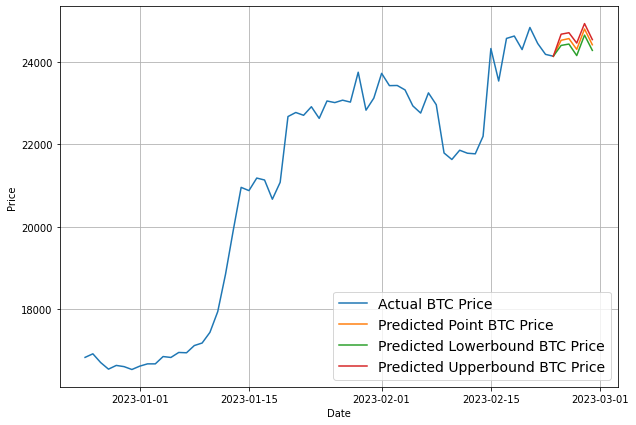

In [59]:
plt.figure(figsize=(10, 7))
plot_time_series(
    data.index,
    data['Price'],
    start=3280,
    format='-',
    label='Actual BTC Price'
)

plot_time_series(
    next_time_steps,
    future_forecast_plot,
    format='-',
    label='Predicted Point BTC Price'
)

plot_time_series(
    next_time_steps,
    lower_future,
    format='-',
    label='Predicted Lowerbound BTC Price'
)

plot_time_series(
    next_time_steps,
    upper_future,
    format='-',
    label='Predicted Upperbound BTC Price'
)

### Make server functions for API

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

import datetime
import os

from lts import LTSCell

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7
BATCH_SIZE = 1024
BTC_PRICES_DATA = 'D:/Uni/FYP/GitHub/BitForecast/ml/data/BTC_Prices.csv'
ENSEMBLE_PATH = 'D:/Uni/FYP/GitHub/BitForecast/server/src/models/ensemble_univariate_complete'

def get_future_dates(start_date, into_future, offset=1):
    '''
    Return dates from start_date to start_date + into_future
    Creates the dates of which the forecast was made
    '''
    
    start_date = start_date + np.timedelta64(offset, 'D')
    end_date = start_date + np.timedelta64(into_future, 'D')
    return np.arange(start_date, end_date, dtype='datetime64[D]')

def create_dataset():
    '''
    Create the required dataset format (Windowing, Cleaning & Spitting)
    '''
    
    # Import data
    data = pd.read_csv(BTC_PRICES_DATA)

    # Clean up data
    data.drop(['volume', 'open', 'max', 'min', 'change_percent'], axis=1, inplace=True)
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data.rename(columns={ 'close': 'Price' }, inplace=True)

    # Create window datasets
    data_windowed = data.copy()
    for i in range(WINDOW_SIZE):
        data_windowed[f'Price+{i+1}'] = data_windowed['Price'].shift(periods=i+1)

    # Create X and y
    X_all = data_windowed.dropna().drop('Price', axis=1).astype(np.float32)
    y_all = data_windowed.dropna()['Price'].astype(np.float32)

    # Convert tensorflow datasets
    features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
    labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)
    dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))
    dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return data, y_all, dataset_all

def create_ensemble(
    num_models=10,
    num_epochs=5000,
    horizon=HORIZON,
    loss_fns=['mae', 'mse', 'mape']
):
    '''
    Create the univariate ensemble model (for the case of retraining)
    '''
    
    _, _, dataset_all = create_dataset()
    ensemble = []

    for i in range(num_models):
        for loss_fn in loss_fns:
            print(f'Model loss: {loss_fn} | model number: {i}')
            model = tf.keras.Sequential([
                tf.keras.layers.Input(
                    shape=(WINDOW_SIZE)
                ),
                tf.keras.layers.Lambda(
                    lambda x: tf.expand_dims(x, axis=1)
                ),
                tf.keras.layers.RNN(
                    LTSCell(16),
                    time_major=True,
                    return_sequences=True
                ),
                tf.keras.layers.LSTM(
                    16,
                    activation='relu'
                ),
                tf.keras.layers.Dense(
                    128,
                    
                    # This is required for the prediction intervals
                    kernel_initializer='he_normal',
                    activation='relu'
                ),
                tf.keras.layers.Dense(
                    128,
                    kernel_initializer='he_normal',
                    activation='relu'
                ),
                tf.keras.layers.Dense(HORIZON)
            ])

            model.compile(
                loss=loss_fn,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse']
            )

            model.fit(
                dataset_all,
                epochs=num_epochs,
                verbose=0,
            )

            ensemble.append(model)

    return ensemble

def save_ensemble():
    '''
    Save ensemble
    '''
    
    for i, model in enumerate(ensemble):
        model.save(f'{ENSEMBLE_PATH}/model_{i}')
        
def load_ensemble():
    '''
    Load ensemble
    '''
    
    ensemble = [tf.keras.models.load_model(f'{ENSEMBLE_PATH}/{model}') for model in os.listdir(ENSEMBLE_PATH)]
    return ensemble

def get_upper_lower(preds):
    '''
    Create prediction uncertainty estimates, for range prediction
    '''
    
    std = tf.math.reduce_std(preds, axis=0)
    # 1.96 is the 97.5th percentile point
    interval = 1.96 * std
    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval
    return lower, upper

def make_future_forecasts(
    values,
    ensemble,
    into_future,
    window_size=WINDOW_SIZE
):
    '''
    Make future perdictions
    '''
    
    future_forecast = []
   
    # Predict {into_future} times with all models in the ensemble
    for i, model in enumerate(ensemble):
        model_forecast = []
        last_window = values[-window_size:] # last {WINDOW_SIZE} prices
        for _ in range(into_future):
            future_pred = tf.squeeze(
                model.predict(tf.expand_dims(last_window, axis=0))
            ).numpy()

            print(f'Model {i} Predicting on:\n{last_window} -> Prediction: {future_pred}')

            # Update future forecast list
            model_forecast.append(future_pred)

            # Update last window: append latest and take last {WINDOW_SIZE} values
            last_window = np.append(last_window, future_pred)[-window_size:]
        
        future_forecast.append(model_forecast)
        
    return future_forecast

def forecast(
    INTO_FUTURE=5
):
    '''
    Create the forecast
    '''
    
    raw_data, y_all, _ = create_dataset()
    ensemble = load_ensemble()

    future_forecast = make_future_forecasts(
        values=y_all,
        ensemble=ensemble,
        into_future=INTO_FUTURE,
        window_size=WINDOW_SIZE
    )
    
    last_timestep = raw_data.index[-1]
    last_price = raw_data['Price'][-1]
    
    next_time_steps = get_future_dates(
        start_date=raw_data.index[-1], 
        into_future=INTO_FUTURE
    )
    
    point_future = np.median(future_forecast, axis=0)
    lower_future, upper_future = get_upper_lower(future_forecast)
    
    next_time_steps = np.insert(next_time_steps, 0, last_timestep)
    point_future = np.insert(point_future, 0, last_price)
    lower_future = np.insert(lower_future, 0, last_price)
    upper_future = np.insert(upper_future, 0, last_price)
    
    return {
        "Predicted For": next_time_steps,
        "Point Forecast": point_future,
        "Lowerbound Forecast": lower_future,
        "Upperbound Forecast": upper_future,
    }